# Alzheimer's Disease Capstone Project
## Machine Learning and Predictive Modeling

The two primary questions that this analysis is trying to answer are:
1. Which biomarkers are correlated with a change in diagnosis to Alzheimer's Disease?
2. Which biomarkers might be able to predict a final diagnosis of Alzhiemer's Disease at an initial visit?

In [1]:
# load packages

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import linear_model
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve

# load custom modules
from adnidatawrangling import wrangle_adni
import eda, ml

# set default plotting
plt.style.use('ggplot')

## 1. Which Biomarkers Are Correlated with a Progression Towards Alzheimer's Disease?
- Steps
    - Prepare data for analysis
        - Import/wrangle/clean
        - Extract the last exam and basline data
        - Calculate the change for each variables (deltas)
        - Extract the features and standardize the data
        - Separate the target and feature data

In [2]:
# import data, clean, and extract data
adni_comp, clin_data, scan_data = wrangle_adni()

# extract final exam data: only the last exam for each patient
final_exam = eda.get_final_exam(adni_comp)

# calculate the change in variables over the course of the study
eda.calc_deltas(final_exam)

# extract and scale the deltas data for ML analysis
feature_names, Xd, yd = ml.get_delta_scaled(final_exam)

In [3]:
# examine the structure of the data
print(feature_names.shape)
print(Xd.shape, yd.shape)

(12,)
(1134, 12) (1134,)


In [4]:
# split the data into test and train sets
Xd_train, Xd_test, yd_train, yd_test = train_test_split(Xd, yd, test_size=0.3, 
                                                    random_state=21, stratify=yd)

#### First Model k-Nearest Neighbors Classification
- The first model will try k-NN to predict the groups
- First, the best k will be chosen
    - Graphic approach
    - GridSearchCV approach

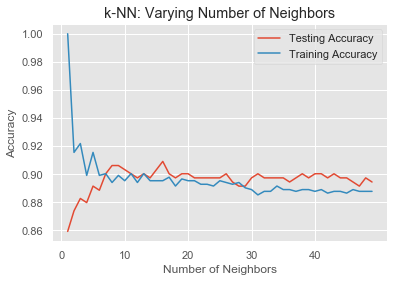

In [5]:
# plot the training and test accuracy with varying k values
ml.plot_best_k(Xd_train, Xd_test, yd_train, yd_test, kmax=50)

- Using this approach, the testing accuracy was highest at k=17. At that point, the testing accuracy appears to slowly start to decrease.

In [6]:
# find best k using GridSearchCV
param_grid = {'n_neighbors': np.arange(1, 50)}

knn = KNeighborsClassifier()

knn_cv = GridSearchCV(knn, param_grid, cv=5)

knn_cv.fit(Xd_train, yd_train)

# print the best value(s) for each hyperparameter and the mean of the best validation score
print(knn_cv.best_params_, knn_cv.best_score_)

{'n_neighbors': 17} 0.8902900378310215


- GridSearchCV returned 17 as the best k, confirming the results from the plot above.

#### k-Nearest Neighbors Model in Action

In [7]:
# create the model
knn = KNeighborsClassifier(n_neighbors=17)

# fit the model
knn.fit(Xd_train, yd_train)

# generate predictions
y_pred = knn.predict(Xd_test)

In [8]:
# print the accuracy
print('Training Accuracy: {}'.format(knn.score(Xd_train, yd_train)))
print('Testing Accuracy: {}'.format(knn.score(Xd_test, yd_test)))

Training Accuracy: 0.8978562421185372
Testing Accuracy: 0.9002932551319648


In [9]:
# print the confusion matrix
print(confusion_matrix(yd_test, y_pred))
tn, fp, fn, tp = confusion_matrix(yd_test, y_pred).ravel()
print('True Negatives: {}'.format(tn))
print('False Positives: {}'.format(fp))
print('False Negatives: {}'.format(fn))
print('True Positives: {}'.format(tp))

[[279   8]
 [ 26  28]]
True Negatives: 279
False Positives: 8
False Negatives: 26
True Positives: 28


- The confusion matrix shows that this model is very good at predicting the true negatives. However, there were more false negatives than true positives, meaning the model does not have much power to detect Alzheimer's disease.
- Analyzing the precision and recall will provide more details.

In [10]:
k = classification_report(yd_test, y_pred, output_dict=True)
print(classification_report(yd_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94       287
           1       0.78      0.52      0.62        54

    accuracy                           0.90       341
   macro avg       0.85      0.75      0.78       341
weighted avg       0.89      0.90      0.89       341



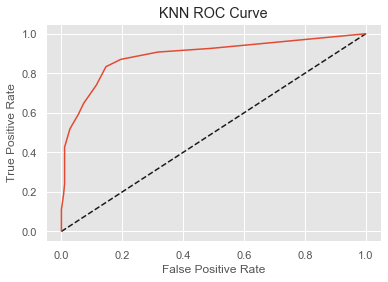

In [11]:
# returns an array with two columns: each column contains probabilities for the target values
# we are selecting the probability of being a 1
y_pred_prob = knn.predict_proba(Xd_test)[:,1]

# unpack into false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(yd_test, y_pred_prob)

_ = plt.plot([0,1], [0,1], 'k--')
_ = plt.plot(fpr, tpr, label='KNN')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('KNN ROC Curve')

In [12]:
# compute the AUC
print(roc_auc_score(yd_test, y_pred_prob))

0.8895341334365727


- The ROC curve and auc score appear to be very good, however, this is an artifact of the imbalanced data, with the model doing very well with true negatives. The precision/recall curve illustrates this below.

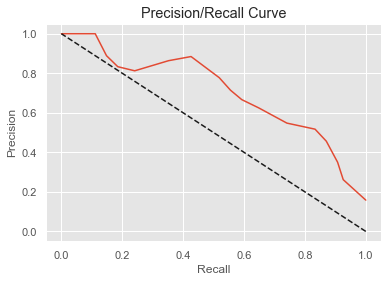

In [13]:
# plot the precision/recall curve
precision, recall, thresholds = precision_recall_curve(yd_test, y_pred_prob)

_ = plt.plot(recall, precision)
_ = plt.plot([1,0], [0,1], 'k--')
_ = plt.xlabel('Recall')
_ = plt.ylabel('Precision')
_ = plt.title('Precision/Recall Curve')

- The precision/recall curve illustrates that recall is not very good at high levels of precision. There is not much predictive value in the model when the precision or sensitivity is high. 

- While it is possible that the model could be improved by oversampling on the Alzheimer's group, different models will be tried that can account for the imbalanced data.

#### SVM Model

In [14]:
# extract and scale the deltas data for ML analysis using -1 and 1 as the classes for SVM
feature_names, Xd, yd = ml.get_delta_scaled(final_exam, neg_one=True)

# split the data into test and train sets
Xd_train, Xd_test, yd_train, yd_test = train_test_split(Xd, yd, test_size=0.3, 
                                                    random_state=21, stratify=yd)

num_features = len(feature_names)

In [15]:
# setup parameters to hyptertune
param_grid = {'C': [0.5, 0.75, 1.0, 1.25, 1.5], 
              'gamma': [(1/(num_features*Xd_train.var())), (1/num_features)]}

svm = SVC(class_weight='balanced', probability=True)

svm_cv = GridSearchCV(svm, param_grid, cv=5)

svm_cv.fit(Xd_train, yd_train)

C = svm_cv.best_params_['C']
gamma = svm_cv.best_params_['gamma']

# print the best value(s) for each hyperparameter and the mean of the best validation score
print(svm_cv.best_params_, svm_cv.best_score_)

{'C': 0.75, 'gamma': 0.08319742133210749} 0.8373266078184111


In [16]:
# create the model
svm = SVC(C=C, gamma=gamma, class_weight='balanced',
         probability=True)

# fit the model
svm.fit(Xd_train, yd_train)

# generate predictions
y_pred = svm.predict(Xd_test)

In [17]:
# print the accuracy
print('The training accuracy was: {}'.format(svm.score(Xd_train, yd_train)))
print('The test accuracy was: {}'.format(svm.score(Xd_test, yd_test)))

The training accuracy was: 0.8776796973518285
The test accuracy was: 0.8533724340175953


In [18]:
# print the confusion matrix
print(confusion_matrix(yd_test, y_pred))
tn, fp, fn, tp = confusion_matrix(yd_test, y_pred).ravel()
print('True Negatives: {}'.format(tn))
print('False Positives: {}'.format(fp))
print('False Negatives: {}'.format(fn))
print('True Positives: {}'.format(tp))

[[245  42]
 [  8  46]]
True Negatives: 245
False Positives: 42
False Negatives: 8
True Positives: 46


- The SVM model did a better job with the true positives vs. false negatives than the knn model when using class weighting to account for the imbalanced data.
- The model did produce 42 false positives, but over 50% of the patients the model flagged as positive did actually develop AD during the study.
- Of the patients that didn't develop AD, only 15% were incorrectly classified as false positive.
- The model had a pretty good detection rate of about 85%.

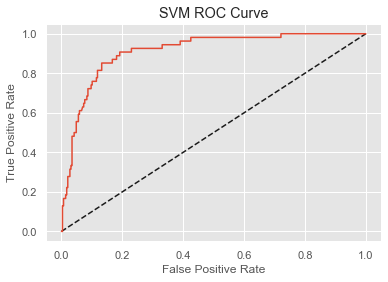

In [19]:
# returns an array with two columns: each column contains probabilities for the target values
# we are selecting the probability of being a 1
y_pred_prob = svm.predict_proba(Xd_test)[:,1]

# unpack into false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(yd_test, y_pred_prob)

_ = plt.plot([0,1], [0,1], 'k--')
_ = plt.plot(fpr, tpr, label='SVM')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('SVM ROC Curve')

In [20]:
s = classification_report(yd_test, y_pred, output_dict=True)
print(classification_report(yd_test, y_pred))

              precision    recall  f1-score   support

          -1       0.97      0.85      0.91       287
           1       0.52      0.85      0.65        54

    accuracy                           0.85       341
   macro avg       0.75      0.85      0.78       341
weighted avg       0.90      0.85      0.87       341



- The recall was much improved for the Alzheimer's class, but at the expense of precision. For this instance, this would be more desirable and a few false positives may be worth higher detection power when predicting AD.

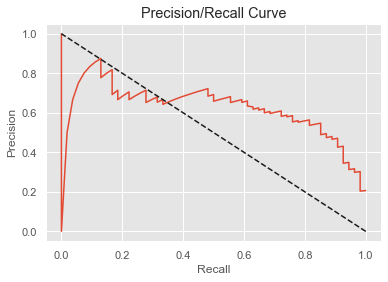

In [21]:
# plot the precision/recall curve
precision, recall, thresholds = precision_recall_curve(yd_test, y_pred_prob)

_ = plt.plot(recall, precision)
_ = plt.plot([1,0], [0,1], 'k--')
_ = plt.xlabel('Recall')
_ = plt.ylabel('Precision')
_ = plt.title('Precision/Recall Curve')

- The precision recall curve once again shows that the model suffers when recall is < 0.4. The model is better at predicting negative results than positive results. For this application, a model that can do well with the Alzheimer's or positive class is desired.

#### Random Forest Classifier

In [22]:
# extract and scale the deltas data for ML analysis using 0 and 1 as the classes for Random Forest
feature_names, Xd, yd = ml.get_delta_scaled(final_exam)

# split the data into test and train sets
Xd_train, Xd_test, yd_train, yd_test = train_test_split(Xd, yd, test_size=0.3, 
                                                    random_state=21, stratify=yd)

In [23]:
# tune hyperparameters n_estimators and max_features
trees = [151, 161, 171, 181, 191]

max_f = [1, 10, 'log2', 'sqrt']

param_grid = {'n_estimators': trees, 'max_features': max_f}

r_forest = RandomForestClassifier(class_weight='balanced', random_state=42)

r_forest_cv = GridSearchCV(r_forest, param_grid, cv=5)

r_forest_cv.fit(Xd_train, yd_train)

n_est = r_forest_cv.best_params_['n_estimators']
n_feat = r_forest_cv.best_params_['max_features']

# print the best value(s) for each hyperparameter and the mean of the best validation score
print(r_forest_cv.best_params_, r_forest_cv.best_score_)

{'max_features': 'log2', 'n_estimators': 181} 0.8953341740226987


In [24]:
# build the model
rfc = RandomForestClassifier(n_estimators=n_est, max_features=n_feat, 
                             class_weight='balanced', random_state=42)

# fit the model
rfc.fit(Xd_train, yd_train)

# generate predictions
y_pred = rfc.predict(Xd_test)

In [25]:
# print the accuracy
print('The training accuracy was: {}'.format(rfc.score(Xd_train, yd_train)))
print('The test accuracy was: {}'.format(rfc.score(Xd_test, yd_test)))

The training accuracy was: 1.0
The test accuracy was: 0.8914956011730205


In [26]:
# print the confusion matrix
print(confusion_matrix(yd_test, y_pred))
tn, fp, fn, tp = confusion_matrix(yd_test, y_pred).ravel()
print('True Negatives: {}'.format(tn))
print('False Positives: {}'.format(fp))
print('False Negatives: {}'.format(fn))
print('True Positives: {}'.format(tp))

[[272  15]
 [ 22  32]]
True Negatives: 272
False Positives: 15
False Negatives: 22
True Positives: 32


- The random forest model did very well with the negative class, but once again failed to perform for the positive class (Alzheimer's disease). 
- Patients that didn't progress to Alzheimer's were predicted pretty accurately, but only 60% of the patients that progressed to Alzheimer's were identified by the model.
- If a doctor is taking a very cautious approach to warning patients, then this could be a good model, with a false positive rate of just 6%.

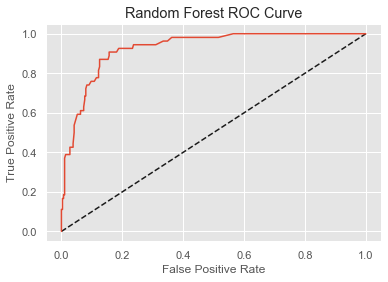

In [27]:
# returns an array with two columns: each column contains probabilities for the target values
# we are selecting the probability of being a 1
y_pred_prob = rfc.predict_proba(Xd_test)[:,1]

# unpack into false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(yd_test, y_pred_prob)

_ = plt.plot([0,1], [0,1], 'k--')
_ = plt.plot(fpr, tpr, label='RFC')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('Random Forest ROC Curve')

In [28]:
r = classification_report(yd_test, y_pred, output_dict=True)
print(classification_report(yd_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       287
           1       0.68      0.59      0.63        54

    accuracy                           0.89       341
   macro avg       0.80      0.77      0.78       341
weighted avg       0.89      0.89      0.89       341



- Both the precision and recall were lower for the positive (AD) class.

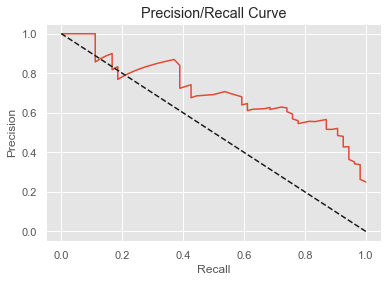

In [29]:
# plot the precision/recall curve
precision, recall, thresholds = precision_recall_curve(yd_test, y_pred_prob)

_ = plt.plot(recall, precision)
_ = plt.plot([1,0], [0,1], 'k--')
_ = plt.xlabel('Recall')
_ = plt.ylabel('Precision')
_ = plt.title('Precision/Recall Curve')

#### AdaBoost for Boosting

In [30]:
# tune hyperparameter number of estimators
est = [61, 71, 81, 91, 101]

param_grid = {'n_estimators': est}

boost = AdaBoostClassifier(random_state=42)

boost_cv = GridSearchCV(boost, param_grid, cv=5)

boost_cv.fit(Xd_train, yd_train)

n_est = boost_cv.best_params_['n_estimators']

# print the best value(s) for each hyperparameter and the mean of the best validation score
print(boost_cv.best_params_, boost_cv.best_score_)

{'n_estimators': 81} 0.8814627994955864


In [31]:
# run the model with the best n_estimators
model = AdaBoostClassifier(n_estimators=n_est, random_state=0)
model.fit(Xd_train, yd_train)
y_pred = model.predict(Xd_test)
print('Training accuracy: {}'.format(model.score(Xd_train, yd_train)))
print('Testing accuracy: {}'.format(model.score(Xd_test, yd_test)))

Training accuracy: 0.9621689785624212
Testing accuracy: 0.8914956011730205


In [32]:
# print the confusion matrix
print(confusion_matrix(yd_test, y_pred))
tn, fp, fn, tp = confusion_matrix(yd_test, y_pred).ravel()
print('True Negatives: {}'.format(tn))
print('False Positives: {}'.format(fp))
print('False Negatives: {}'.format(fn))
print('True Positives: {}'.format(tp))

[[268  19]
 [ 18  36]]
True Negatives: 268
False Positives: 19
False Negatives: 18
True Positives: 36


- Boosting improved on the random forest model for prediction power, with 2/3 of the 54 patients with AD being correctly identified.
- The model still failed to detect progression to AD in 18 patients, however.
- This model might be preferred by cautious doctors that would rather have false negatives than false positives.

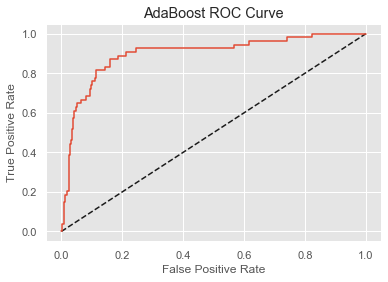

In [33]:
# returns an array with two columns: each column contains probabilities for the target values
# we are selecting the probability of being a 1
y_pred_prob = model.predict_proba(Xd_test)[:,1]

# unpack into false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(yd_test, y_pred_prob)

_ = plt.plot([0,1], [0,1], 'k--')
_ = plt.plot(fpr, tpr, label='Boost')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('AdaBoost ROC Curve')

In [34]:
b = classification_report(yd_test, y_pred, output_dict=True)
print(classification_report(yd_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.93      0.94       287
           1       0.65      0.67      0.66        54

    accuracy                           0.89       341
   macro avg       0.80      0.80      0.80       341
weighted avg       0.89      0.89      0.89       341



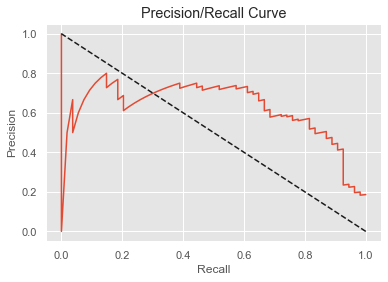

In [35]:
# plot the precision/recall curve
precision, recall, thresholds = precision_recall_curve(yd_test, y_pred_prob)

_ = plt.plot(recall, precision)
_ = plt.plot([1,0], [0,1], 'k--')
_ = plt.xlabel('Recall')
_ = plt.ylabel('Precision')
_ = plt.title('Precision/Recall Curve')

- The precision recall curve again shows the tradeoff in prediction power with high precision.
- Overall, the model's performance is not satisfactory for prediction a progression to AD.

- Simple feature selection using feature_importances_

In [36]:
# get the feature importances in a dataframe
feat = pd.DataFrame({'feature': feature_names, 'importance': model.feature_importances_})
feat.sort_values('importance', ascending=False)

,feature,importance
5,Hippocampus_delta,0.135802
6,Ventricles_delta,0.135802
11,AGE,0.135802
0,CDRSB_delta,0.123457
7,WholeBrain_delta,0.111111
8,Entorhinal_delta,0.086420
9,MidTemp_delta,0.086420
1,ADAS11_delta,0.061728
3,MMSE_delta,0.049383
2,ADAS13_delta,0.037037


In [37]:
# omit zero/low importance features and run the model again
mask = (feature_names != 'ADAS13_delta') & (feature_names != 'RAVLT_delta') & (feature_names != 'PTGENDER_Male')
Xtrain_reduced = Xd_train[:,mask]
Xtest_reduced = Xd_test[:,mask]

est = [1, 11, 21, 31, 41]
param_grid = {'n_estimators': est}
boost = AdaBoostClassifier(random_state=42)
boost_cv = GridSearchCV(boost, param_grid, cv=5)
boost_cv.fit(Xtrain_reduced, yd_train)
n_est = boost_cv.best_params_['n_estimators']
print(boost_cv.best_params_, boost_cv.best_score_)

{'n_estimators': 31} 0.8814627994955864


In [38]:
# run the model with the best n_estimators
model = AdaBoostClassifier(n_estimators=n_est, random_state=0)
model.fit(Xtrain_reduced, yd_train)
y_pred = model.predict(Xtest_reduced)
print('Training accuracy: {}'.format(model.score(Xtrain_reduced, yd_train)))
print('Testing accuracy: {}'.format(model.score(Xtest_reduced, yd_test)))

Training accuracy: 0.9281210592686002
Testing accuracy: 0.8914956011730205


In [39]:
# print the confusion matrix
print(confusion_matrix(yd_test, y_pred))
tn, fp, fn, tp = confusion_matrix(yd_test, y_pred).ravel()
print('True Negatives: {}'.format(tn))
print('False Positives: {}'.format(fp))
print('False Negatives: {}'.format(fn))
print('True Positives: {}'.format(tp))

[[267  20]
 [ 17  37]]
True Negatives: 267
False Positives: 20
False Negatives: 17
True Positives: 37


- The model is very similar to the full feature model, trading one additional true positive for three false negatives. As the goal of this analysis is to predict patients that may be at a higher risk of Alzheimer's, I would consider this an improvement on the original model.

#### Logistic Regression

In [40]:
# build the model
logreg = linear_model.LogisticRegression(solver='lbfgs', class_weight='balanced', random_state=42)

# fit the model
logreg.fit(Xd_train, yd_train)

# generate predictions
y_pred = logreg.predict(Xd_test)

In [41]:
# print the accuracy
print('The training accuracy was: {}'.format(logreg.score(Xd_train, yd_train)))
print('The test accuracy was: {}'.format(logreg.score(Xd_test, yd_test)))

The training accuracy was: 0.8663303909205549
The test accuracy was: 0.8651026392961877


In [42]:
# print the confusion matrix
print(confusion_matrix(yd_test, y_pred))
tn, fp, fn, tp = confusion_matrix(yd_test, y_pred).ravel()
print('True Negatives: {}'.format(tn))
print('False Positives: {}'.format(fp))
print('False Negatives: {}'.format(fn))
print('True Positives: {}'.format(tp))

[[249  38]
 [  8  46]]
True Negatives: 249
False Positives: 38
False Negatives: 8
True Positives: 46


- The logistic model performed better at identifying patients that progressed to AD at the expense of adding more false positives.
- This model would be preferred by physicians that would rather catch every patient at a high risk of AD while not as concerned with false positives.
- While there were 38 false positives, 249/287 (87%) of the patients that didn't progress to AD were correctly identified by this model.
- The detection rate was pretty high at 46/54 or about 85%.
- This the best model tied with SVM for predictive power but had fewer false positives.

In [43]:
l = classification_report(yd_test, y_pred, output_dict=True)
print(classification_report(yd_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.87      0.92       287
           1       0.55      0.85      0.67        54

    accuracy                           0.87       341
   macro avg       0.76      0.86      0.79       341
weighted avg       0.90      0.87      0.88       341



- The recall (detection rate) was much higher for the positive class, and the negative detection rate of 85% was also good. Precision was not great for the Alzheimer's class, with only about half of those identified as at risk for AD were diagnosed with the disease by the end of the study.
- Still, of these patients, some may have been diagnosed after the study, and this may be an acceptable rate when the recall rates are considered.

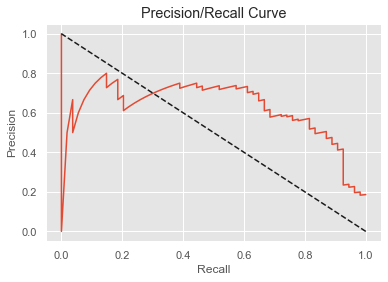

In [44]:
# plot the precision/recall curve
precision, recall, thresholds = precision_recall_curve(yd_test, y_pred_prob)

_ = plt.plot(recall, precision)
_ = plt.plot([1,0], [0,1], 'k--')
_ = plt.xlabel('Recall')
_ = plt.ylabel('Precision')
_ = plt.title('Precision/Recall Curve')

- Once again, the precision was low, but this is partly due to the imbalanced data. This model has performed the best so far. The ROC-AUC metrics support this.

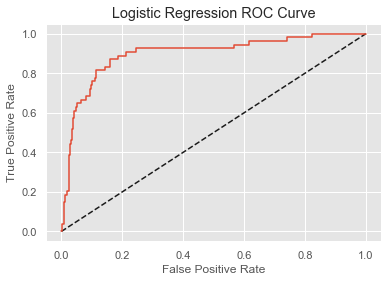

In [45]:
# unpack into false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(yd_test, y_pred_prob)

_ = plt.plot([0,1], [0,1], 'k--')
_ = plt.plot(fpr, tpr, label='Logistic Regression')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('Logistic Regression ROC Curve')

In [46]:
# compute the AUC
print(roc_auc_score(yd_test, y_pred_prob))

0.8967608723706284


- Simple feature selection using the coefficients from the logistic model

In [47]:
# print the coefficients for understanding feature importance
feat = pd.DataFrame({'feature': feature_names, 'coefficients': logreg.coef_[0]})
feat.loc[:,'abs_c'] = abs(feat.coefficients)
feat.sort_values('abs_c', ascending=False)

,feature,coefficients,abs_c
0,CDRSB_delta,1.638069,1.638069
2,ADAS13_delta,0.830348,0.830348
1,ADAS11_delta,-0.585011,0.585011
5,Hippocampus_delta,-0.476625,0.476625
3,MMSE_delta,-0.461078,0.461078
7,WholeBrain_delta,0.391896,0.391896
11,AGE,-0.377201,0.377201
6,Ventricles_delta,0.341546,0.341546
10,PTGENDER_Male,0.235055,0.235055
8,Entorhinal_delta,-0.205870,0.205870


In [48]:
# running the model without MidTemp_delta
mask = feat.feature != 'MidTemp_delta'
Xtrain_reduced = Xd_train[:,mask]
Xtest_reduced = Xd_test[:,mask]

In [49]:
# build the model
logreg2 = linear_model.LogisticRegression(solver='lbfgs', class_weight='balanced', random_state=42)

# fit the model
logreg2.fit(Xtrain_reduced, yd_train)

# generate predictions
y_pred = logreg2.predict(Xtest_reduced)

In [50]:
# print the accuracy
print('The training accuracy was: {}'.format(logreg2.score(Xtrain_reduced, yd_train)))
print('The test accuracy was: {}'.format(logreg2.score(Xtest_reduced, yd_test)))

The training accuracy was: 0.8663303909205549
The test accuracy was: 0.8651026392961877


In [51]:
# print the confusion matrix
print(confusion_matrix(yd_test, y_pred))
tn, fp, fn, tp = confusion_matrix(yd_test, y_pred).ravel()
print('True Negatives: {}'.format(tn))
print('False Positives: {}'.format(fp))
print('False Negatives: {}'.format(fn))
print('True Positives: {}'.format(tp))

[[249  38]
 [  8  46]]
True Negatives: 249
False Positives: 38
False Negatives: 8
True Positives: 46


- Model performance was identical to the full feature model.

#### Naive Bayes

In [52]:
# get rid of negative values in the feature data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(Xd_train)

# instantize the model
model = MultinomialNB()

# fit the model
model.fit(X_scaled, yd_train)

# generate predictions
y_pred = model.predict(Xd_test)

In [53]:
# print the accuracy
print('The training accuracy was: {}'.format(model.score(X_scaled, yd_train)))
print('The test accuracy was: {}'.format(model.score(Xd_test, yd_test)))

The training accuracy was: 0.8411097099621689
The test accuracy was: 0.841642228739003


In [54]:
# print the confusion matrix
print(confusion_matrix(yd_test, y_pred))
tn, fp, fn, tp = confusion_matrix(yd_test, y_pred).ravel()
print('True Negatives: {}'.format(tn))
print('False Positives: {}'.format(fp))
print('False Negatives: {}'.format(fn))
print('True Positives: {}'.format(tp))

[[253  34]
 [ 20  34]]
True Negatives: 253
False Positives: 34
False Negatives: 20
True Positives: 34


- Naive Bayes was not very effective at predicing AD with a 63% detection rate.
- Like some of the other models, this model performed better on the negative class, with 88% of the negative classifications being correct.
- This model underperformed with respect to detecting AD, but could be useful if a doctor is wanting to avoid false positives.

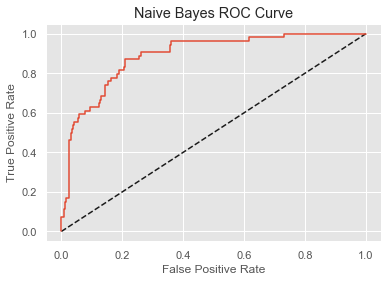

In [55]:
# returns an array with two columns: each column contains probabilities for the target values
# we are selecting the probability of being a 1
y_pred_prob = model.predict_proba(Xd_test)[:,1]

# unpack into false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(yd_test, y_pred_prob)

_ = plt.plot([0,1], [0,1], 'k--')
_ = plt.plot(fpr, tpr, label='NB')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('Naive Bayes ROC Curve')

In [56]:
n = classification_report(yd_test, y_pred, output_dict=True)
print(classification_report(yd_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.88      0.90       287
           1       0.50      0.63      0.56        54

    accuracy                           0.84       341
   macro avg       0.71      0.76      0.73       341
weighted avg       0.86      0.84      0.85       341



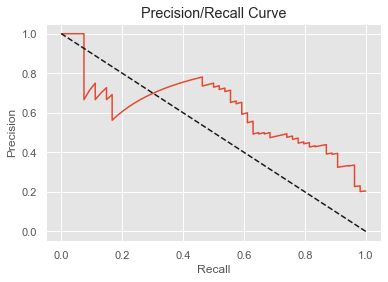

In [57]:
# plot the precision/recall curve
y_pred_prob = model.predict_proba(Xd_test)[:,1]
precision, recall, thresholds = precision_recall_curve(yd_test, y_pred_prob)

_ = plt.plot(recall, precision)
_ = plt.plot([1,0], [0,1], 'k--')
_ = plt.xlabel('Recall')
_ = plt.ylabel('Precision')
_ = plt.title('Precision/Recall Curve')

- The precision recall plot illustrates the lack of prediction power when precision is high.

## 1. Question One Summary: Detecting a Progression to Alzheimer's by Analyzing Changes in Biomarkers
- The Logistic Regression model performed the best at detecting AD, along with AdaBoost and SVM.
    - These were the best models for detection power, producing the least amount of false negatives.
    - Each of these three models had higher false positive rates than the other models, but my opinion is that a certain number of false positives is acceptable for trying to start early brain training excercises to prevent AD.
    - The overall false positive rates were still low, considering the total number of patients that did not develop AD, and model performance was good for the Non AD class for all models (red bars).
- Several models performed well on the negative class, at the expense of losing detection power for Alzheimer's Disease.

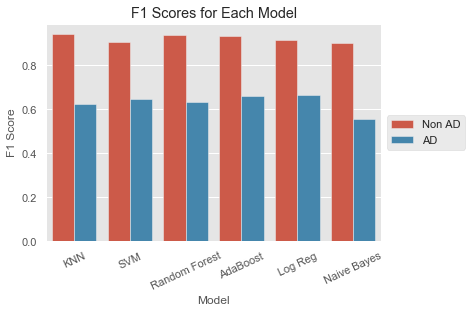

In [58]:
# plot the f1-scores for each model
ml.plot_f1_scores(k, s, r, b, l, n)

## 2. Can Baseline Biomarkers Be Used to Predict Alzheimer's?

In [59]:
# extract just the baseline data features
feature_names, Xb, yb = ml.get_bl_data(final_exam)

In [60]:
# examine the shape of the arrays
print(Xb.shape, yb.shape)

(1170, 12) (1170,)


In [61]:
# split the data into training and test datasets
Xb_train, Xb_test, yb_train, yb_test = train_test_split(Xb, yb, test_size=0.3, 
                                                    random_state=21, stratify=yb)

#### k-NN model

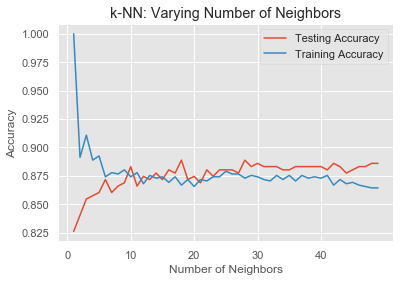

In [62]:
# plot the training and test accuracy with varying k values
ml.plot_best_k(Xb_train, Xb_test, yb_train, yb_test, kmax=50)

- A graphical approach suggests that 18 or higher would be a good choice. Seeing as this is one test run of the data, cross validation may provide a slightly different result.

In [63]:
# find best k using GridSearchCV
param_grid = {'n_neighbors': np.arange(1, 50)}

knn = KNeighborsClassifier()

knn_cv = GridSearchCV(knn, param_grid, cv=5)

knn_cv.fit(Xb_train, yb_train)

# print the best value(s) for each hyperparameter and the mean of the best validation score
print(knn_cv.best_params_, knn_cv.best_score_)

{'n_neighbors': 23} 0.8705738705738706


- The best k when chosen over five cross validation folds is 23 neighbors, and that is what will be used for the model.

In [64]:
# create the model
knn = KNeighborsClassifier(n_neighbors=23)

# fit the model
knn.fit(Xb_train, yb_train)

# generate predictions
y_pred = knn.predict(Xb_test)

In [65]:
# print the accuracy
print('Training Accuracy: {}'.format(knn.score(Xb_train, yb_train)))
print('Testing Accuracy: {}'.format(knn.score(Xb_test, yb_test)))

Training Accuracy: 0.8742368742368742
Testing Accuracy: 0.8746438746438746


In [66]:
# print the confusion matrix
print(confusion_matrix(yb_test, y_pred))
tn, fp, fn, tp = confusion_matrix(yb_test, y_pred).ravel()
print('True Negatives: {}'.format(tn))
print('False Positives: {}'.format(fp))
print('False Negatives: {}'.format(fn))
print('True Positives: {}'.format(tp))

[[227  18]
 [ 26  80]]
True Negatives: 227
False Positives: 18
False Negatives: 26
True Positives: 80


- Right away, this model shows some predictive value for Alzheimer's disease using only baseline data. There were 26 false negatives, but this only represents about 25% of those with AD, meaning this model had a 75% detection rate.
- To achieve this, there were some false positives, but only about 8% of patients that didn't develop AD would have been flagged as at risk.
- This model shows value immediately with a very low false positive rate and a potentially acceptable detection rate. Doctors that wanted to take a conservative approach to warning patients would do well to choose this model.

In [67]:
k = classification_report(yb_test, y_pred, output_dict=True)
print(classification_report(yb_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.93      0.91       245
           1       0.82      0.75      0.78       106

    accuracy                           0.87       351
   macro avg       0.86      0.84      0.85       351
weighted avg       0.87      0.87      0.87       351



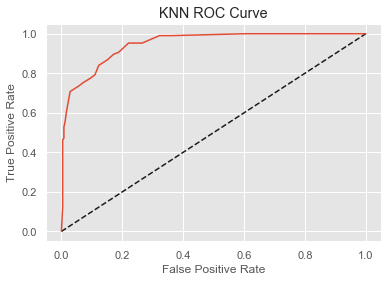

In [68]:
# returns an array with two columns: each column contains probabilities for the target values
# we are selecting the probability of being a 1
y_pred_prob = knn.predict_proba(Xb_test)[:,1]

# unpack into false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(yb_test, y_pred_prob)

_ = plt.plot([0,1], [0,1], 'k--')
_ = plt.plot(fpr, tpr, label='KNN')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('KNN ROC Curve')

In [69]:
# compute the AUC
print(roc_auc_score(yb_test, y_pred_prob))

0.9477088948787062


- The AUC score was very high, nearly 95%. This measure is slightly skewed by the performance on the non-AD patients, but the data are less imbalanced than for the first question, so this is further evidence that this is a decent model.

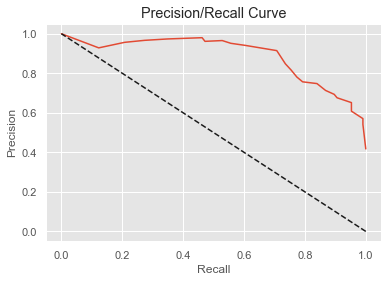

In [70]:
# plot the precision/recall curve
precision, recall, thresholds = precision_recall_curve(yb_test, y_pred_prob)

_ = plt.plot(recall, precision)
_ = plt.plot([1,0], [0,1], 'k--')
_ = plt.xlabel('Recall')
_ = plt.ylabel('Precision')
_ = plt.title('Precision/Recall Curve')

- The precision recall curve already looks better than any of the curves for the first question examining changes in biomarkers. 
- The first attempt at building a model to predict AD from baseline biomarkers was successful, but additional algorithms will be tried in an attempt to improve predictions.

#### SVM

In [71]:
# extract and scale the baseline data for ML analysis using -1 and 1 as the classes for SVM
feature_names, Xb, yb = ml.get_bl_data(final_exam, neg_one=True)

# split the data into test and train sets
Xb_train, Xb_test, yb_train, yb_test = train_test_split(Xb, yb, test_size=0.3, 
                                                    random_state=21, stratify=yb)

num_features = len(feature_names)

In [72]:
# setup parameters to hyptertune
param_grid = {'C': [0.5, 0.75, 1.0, 1.25, 1.5], 
              'gamma': [(1/(num_features*Xd_train.var())), (1/num_features)]}

svm = SVC(class_weight='balanced', probability=True)

svm_cv = GridSearchCV(svm, param_grid, cv=5)

svm_cv.fit(Xb_train, yb_train)

C = svm_cv.best_params_['C']
gamma = svm_cv.best_params_['gamma']

# print the best value(s) for each hyperparameter and the mean of the best validation score
print(svm_cv.best_params_, svm_cv.best_score_)

{'C': 1.0, 'gamma': 0.08319742133210749} 0.8620268620268621


In [73]:
# create the model
svm = SVC(C=C, gamma=gamma, class_weight='balanced',
         probability=True)

# fit the model
svm.fit(Xb_train, yb_train)

# generate predictions
y_pred = svm.predict(Xb_test)

In [74]:
# print the accuracy
print('The training accuracy was: {}'.format(svm.score(Xb_train, yb_train)))
print('The test accuracy was: {}'.format(svm.score(Xb_test, yb_test)))

The training accuracy was: 0.8925518925518926
The test accuracy was: 0.8547008547008547


In [75]:
# print the confusion matrix
print(confusion_matrix(yb_test, y_pred))
tn, fp, fn, tp = confusion_matrix(yb_test, y_pred).ravel()
print('True Negatives: {}'.format(tn))
print('False Positives: {}'.format(fp))
print('False Negatives: {}'.format(fn))
print('True Positives: {}'.format(tp))

[[205  40]
 [ 11  95]]
True Negatives: 205
False Positives: 40
False Negatives: 11
True Positives: 95


- Like with the first question, the SVM model improves on k-NN for detection power. This model had a 90% detection rate for Alzheimer's disease just using data from patients' first visit!
- This model improvement did come at the expense of additional false positives, however, the false positive rate was just 16%. 
- This model would be a good choice for a doctor that wanted to catch most of the patients that would progrss to AD eventually, if they were ok with informing a few patients that they were higher risk, when they may not end up progressing to AD.

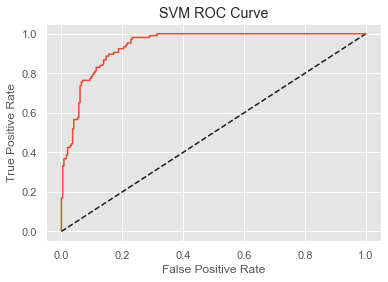

In [76]:
# returns an array with two columns: each column contains probabilities for the target values
# we are selecting the probability of being a 1
y_pred_prob = svm.predict_proba(Xb_test)[:,1]

# unpack into false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(yb_test, y_pred_prob)

_ = plt.plot([0,1], [0,1], 'k--')
_ = plt.plot(fpr, tpr, label='SVM')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('SVM ROC Curve')

In [77]:
# compute the AUC
print(roc_auc_score(yb_test, y_pred_prob))

0.9411436272622257


In [78]:
s = classification_report(yb_test, y_pred, output_dict=True)
print(classification_report(yb_test, y_pred))

              precision    recall  f1-score   support

          -1       0.95      0.84      0.89       245
           1       0.70      0.90      0.79       106

    accuracy                           0.85       351
   macro avg       0.83      0.87      0.84       351
weighted avg       0.87      0.85      0.86       351



- As expected, the AUC score was higher than the F1 scores for either group, most likely attributable to imbalanced data, however, this model was still an improvement over k-NN, with a slightly lower AUC score, but a higher recall for the AD class.

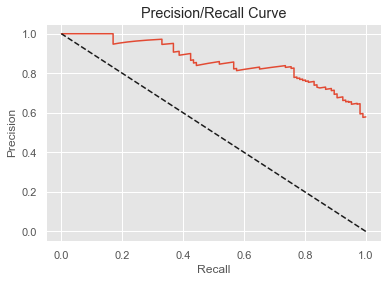

In [79]:
# plot the precision/recall curve
precision, recall, thresholds = precision_recall_curve(yb_test, y_pred_prob)

_ = plt.plot(recall, precision)
_ = plt.plot([1,0], [0,1], 'k--')
_ = plt.xlabel('Recall')
_ = plt.ylabel('Precision')
_ = plt.title('Precision/Recall Curve')

- The precision/recall curve looks pretty good for this model, creeping up to the 1.0/1.0 value that is desired in the top right corner.

#### Random Forest

In [80]:
# extract and scale the baseline data for ML analysis using 0 and 1 as the classes for Random Forest
feature_names, Xb, yb = ml.get_bl_data(final_exam)

# split the data into test and train sets
Xb_train, Xb_test, yb_train, yb_test = train_test_split(Xb, yb, test_size=0.3, 
                                                    random_state=21, stratify=yb)

In [81]:
# tune hyperparameters n_estimators and max_features
trees = [131, 141, 151, 161, 171]

max_f = [1, 10, 'log2', 'sqrt']

param_grid = {'n_estimators': trees, 'max_features': max_f}

r_forest = RandomForestClassifier(class_weight='balanced', random_state=42)

r_forest_cv = GridSearchCV(r_forest, param_grid, cv=5)

r_forest_cv.fit(Xb_train, yb_train)

n_est = r_forest_cv.best_params_['n_estimators']
n_feat = r_forest_cv.best_params_['max_features']

# print the best value(s) for each hyperparameter and the mean of the best validation score
print(r_forest_cv.best_params_, r_forest_cv.best_score_)

{'max_features': 1, 'n_estimators': 151} 0.873015873015873


In [82]:
# build the model
rfc = RandomForestClassifier(n_estimators=n_est, max_features=n_feat, 
                             class_weight='balanced', random_state=42)

# fit the model
rfc.fit(Xb_train, yb_train)

# generate predictions
y_pred = rfc.predict(Xb_test)

In [83]:
# print the accuracy
print('The training accuracy was: {}'.format(rfc.score(Xb_train, yb_train)))
print('The test accuracy was: {}'.format(rfc.score(Xb_test, yb_test)))

The training accuracy was: 1.0
The test accuracy was: 0.8461538461538461


In [84]:
# print the confusion matrix
print(confusion_matrix(yb_test, y_pred))
tn, fp, fn, tp = confusion_matrix(yb_test, y_pred).ravel()
print('True Negatives: {}'.format(tn))
print('False Positives: {}'.format(fp))
print('False Negatives: {}'.format(fn))
print('True Positives: {}'.format(tp))

[[216  29]
 [ 25  81]]
True Negatives: 216
False Positives: 29
False Negatives: 25
True Positives: 81


- The Random Forest model was not bad, and it had a detection rate of 76%. This is slightly better than k-NN but not quite as good as the SVM model.
- The false positive rate was just 13%, so there was a tradeoff with a loss of prediction power but a good false positive rate. 
- This model, like k-NN, would be well suited for someone that didn't want a high false positive rate. The predictive power is still relatively high, and about 76% of patients that developed AD could have been notified that they are higher risk at a first visit.

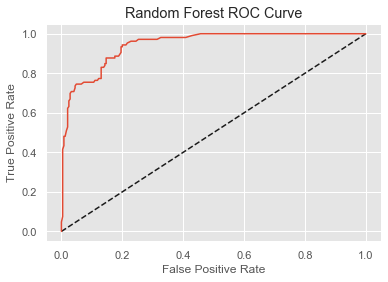

In [85]:
# returns an array with two columns: each column contains probabilities for the target values
# we are selecting the probability of being a 1
y_pred_prob = rfc.predict_proba(Xb_test)[:,1]

# unpack into false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(yb_test, y_pred_prob)

_ = plt.plot([0,1], [0,1], 'k--')
_ = plt.plot(fpr, tpr, label='RFC')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('Random Forest ROC Curve')

In [86]:
# compute the AUC
print(roc_auc_score(yb_test, y_pred_prob))

0.9440893338467462


In [87]:
r = classification_report(yb_test, y_pred, output_dict=True)
print(classification_report(yb_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.88      0.89       245
           1       0.74      0.76      0.75       106

    accuracy                           0.85       351
   macro avg       0.82      0.82      0.82       351
weighted avg       0.85      0.85      0.85       351



- Precision and recall scores were pretty good, with F1-scores of 0.77 for AD and 0.90 for non AD.

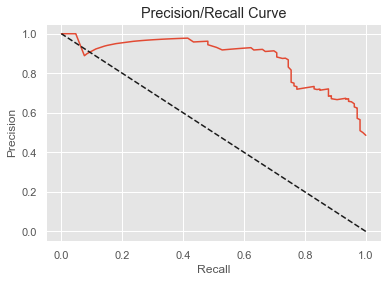

In [88]:
# plot the precision/recall curve
precision, recall, thresholds = precision_recall_curve(yb_test, y_pred_prob)

_ = plt.plot(recall, precision)
_ = plt.plot([1,0], [0,1], 'k--')
_ = plt.xlabel('Recall')
_ = plt.ylabel('Precision')
_ = plt.title('Precision/Recall Curve')

- So far, this model is close to competing with SVM for the best choice, depending on the circumstance.

#### AdaBoost

In [89]:
# tune hyperparameter number of estimators
est = [21, 31, 41, 51, 61, 71, 81]

param_grid = {'n_estimators': est}

boost = AdaBoostClassifier(random_state=42)

boost_cv = GridSearchCV(boost, param_grid, cv=5)

boost_cv.fit(Xb_train, yb_train)

n_est = boost_cv.best_params_['n_estimators']

# print the best value(s) for each hyperparameter and the mean of the best validation score
print(boost_cv.best_params_, boost_cv.best_score_)

{'n_estimators': 41} 0.851037851037851


In [90]:
# run the model with the best n_estimators
model = AdaBoostClassifier(n_estimators=n_est, random_state=0)
model.fit(Xb_train, yb_train)
y_pred = model.predict(Xb_test)
print('Training accuracy: {}'.format(model.score(Xb_train, yb_train)))
print('Testing accuracy: {}'.format(model.score(Xb_test, yb_test)))

Training accuracy: 0.8974358974358975
Testing accuracy: 0.8632478632478633


In [91]:
# print the confusion matrix
print(confusion_matrix(yb_test, y_pred))
tn, fp, fn, tp = confusion_matrix(yb_test, y_pred).ravel()
print('True Negatives: {}'.format(tn))
print('False Positives: {}'.format(fp))
print('False Negatives: {}'.format(fn))
print('True Positives: {}'.format(tp))

[[219  26]
 [ 22  84]]
True Negatives: 219
False Positives: 26
False Negatives: 22
True Positives: 84


- This model slightly improved on the Random Forest model, with a detection rate of 79% and a false positive rate of 11%. 
- This could be a very good choice for a model for someone that wanted a middle of the road approach to predicting AD. The detection rate is pretty high at nearly 4/5, and the false positive rate is acceptably low at just 11% for patients that wouldn't develop AD (in the time frame of this study).
- While not the best model for detecting AD or the best for reducing false positives, this model may be the best compromise between those options.

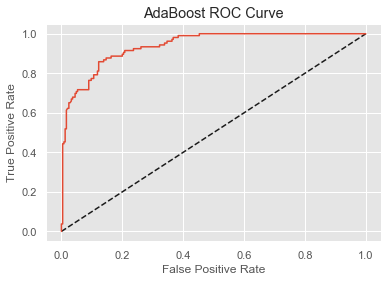

In [92]:
# returns an array with two columns: each column contains probabilities for the target values
# we are selecting the probability of being a 1
y_pred_prob = model.predict_proba(Xb_test)[:,1]

# unpack into false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(yb_test, y_pred_prob)

_ = plt.plot([0,1], [0,1], 'k--')
_ = plt.plot(fpr, tpr, label='Boost')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('AdaBoost ROC Curve')

In [93]:
# compute the AUC
print(roc_auc_score(yb_test, y_pred_prob))

0.9381209087408549


In [94]:
b = classification_report(yb_test, y_pred, output_dict=True)
print(classification_report(yb_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.89      0.90       245
           1       0.76      0.79      0.78       106

    accuracy                           0.86       351
   macro avg       0.84      0.84      0.84       351
weighted avg       0.86      0.86      0.86       351



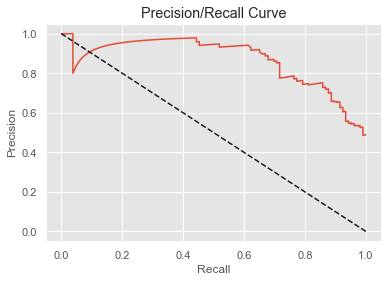

In [95]:
# plot the precision/recall curve
precision, recall, thresholds = precision_recall_curve(yb_test, y_pred_prob)

_ = plt.plot(recall, precision)
_ = plt.plot([1,0], [0,1], 'k--')
_ = plt.xlabel('Recall')
_ = plt.ylabel('Precision')
_ = plt.title('Precision/Recall Curve')

- The precision, recall, and F1-scores were pretty good for this model. The precision/recall curve is displaying the usual tradeoff in recall at high precision levels, but overall this was a good model that would be useful for predicting Alzheimer's disease.

- Simple feature selection using feature_importances_

In [96]:
# get the feature importances in a dataframe
feat = pd.DataFrame({'feature': feature_names, 'importance': model.feature_importances_})
feat.sort_values('importance', ascending=False)

,feature,importance
11,AGE,0.195122
9,MidTemp_bl,0.170732
0,CDRSB_bl,0.121951
6,Ventricles_bl,0.121951
8,Entorhinal_bl,0.097561
2,ADAS13_bl,0.073171
4,RAVLT_immediate_bl,0.073171
3,MMSE_bl,0.048780
5,Hippocampus_bl,0.048780
7,WholeBrain_bl,0.048780


In [97]:
# omit zero importance features and run the model again
mask = (feature_names != 'ADAS11_bl') & (feature_names != 'PTGENDER_Male')
Xtrain_reduced = Xb_train[:,mask]
Xtest_reduced = Xb_test[:,mask]

est = [1, 11, 21, 31, 41]
param_grid = {'n_estimators': est}
boost = AdaBoostClassifier(random_state=42)
boost_cv = GridSearchCV(boost, param_grid, cv=5)
boost_cv.fit(Xtrain_reduced, yb_train)
n_est = boost_cv.best_params_['n_estimators']
print(boost_cv.best_params_, boost_cv.best_score_)

{'n_estimators': 11} 0.8571428571428571


In [98]:
# run the model with the best n_estimators
model = AdaBoostClassifier(n_estimators=n_est, random_state=0)
model.fit(Xtrain_reduced, yb_train)
y_pred = model.predict(Xtest_reduced)
print('Training accuracy: {}'.format(model.score(Xtrain_reduced, yb_train)))
print('Testing accuracy: {}'.format(model.score(Xtest_reduced, yb_test)))

Training accuracy: 0.8681318681318682
Testing accuracy: 0.8689458689458689


In [99]:
# print the confusion matrix
print(confusion_matrix(yb_test, y_pred))
tn, fp, fn, tp = confusion_matrix(yb_test, y_pred).ravel()
print('True Negatives: {}'.format(tn))
print('False Positives: {}'.format(fp))
print('False Negatives: {}'.format(fn))
print('True Positives: {}'.format(tp))

[[219  26]
 [ 20  86]]
True Negatives: 219
False Positives: 26
False Negatives: 20
True Positives: 86


- The model improved slightly, with 81% detection rate and maitaining the 11% false positive rate.

#### Logistic Regression

In [100]:
# build the model
logreg = linear_model.LogisticRegression(solver='lbfgs', class_weight='balanced', random_state=42)

# fit the model
logreg.fit(Xb_train, yb_train)

# generate predictions
y_pred = logreg.predict(Xb_test)

In [101]:
# print the accuracy
print('The training accuracy was: {}'.format(logreg.score(Xb_train, yb_train)))
print('The test accuracy was: {}'.format(logreg.score(Xb_test, yb_test)))

The training accuracy was: 0.8656898656898657
The test accuracy was: 0.8831908831908832


In [102]:
# print the confusion matrix
print(confusion_matrix(yb_test, y_pred))
tn, fp, fn, tp = confusion_matrix(yb_test, y_pred).ravel()
print('True Negatives: {}'.format(tn))
print('False Positives: {}'.format(fp))
print('False Negatives: {}'.format(fn))
print('True Positives: {}'.format(tp))

[[212  33]
 [  8  98]]
True Negatives: 212
False Positives: 33
False Negatives: 8
True Positives: 98


- As with the change in biomarkers, logistic regression has shown to have the highest prediction power so far with a 92% detection rate and a 13% false positive rate.
- This model has fantastic performance. If it were me, I would be fine with a 13% false positive rate for a 92% detection rate for AD.
- I would be fine alerting 13% of people who wouldn't be diagnosed with AD that they are at higher risk of the disease and should start brain training exercises and begin early treatment to achieve the 92% detection rate.

In [103]:
l = classification_report(yb_test, y_pred, output_dict=True)
print(classification_report(yb_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.87      0.91       245
           1       0.75      0.92      0.83       106

    accuracy                           0.88       351
   macro avg       0.86      0.89      0.87       351
weighted avg       0.90      0.88      0.89       351



- Precision suffers a little at the expense of recall for this model, however, the F1-scores for both the non-AD class and AD class are pretty high (0.91 and 0.83).

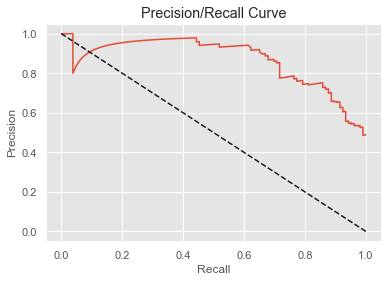

In [104]:
# plot the precision/recall curve
precision, recall, thresholds = precision_recall_curve(yb_test, y_pred_prob)

_ = plt.plot(recall, precision)
_ = plt.plot([1,0], [0,1], 'k--')
_ = plt.xlabel('Recall')
_ = plt.ylabel('Precision')
_ = plt.title('Precision/Recall Curve')

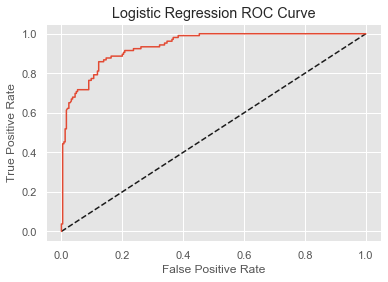

In [105]:
# unpack into false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(yb_test, y_pred_prob)

_ = plt.plot([0,1], [0,1], 'k--')
_ = plt.plot(fpr, tpr, label='Logistic Regression')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('Logistic Regression ROC Curve')

In [106]:
# compute the AUC
print(roc_auc_score(yb_test, y_pred_prob))

0.9381209087408549


- Again, the tradeoff of recall at high precision is evident, but the precision does not drop as quickly as recall increases as some of the other models.
- The AUC is a very good score, slightly skewed by the negative class, but it shows that this model works very well.

- Simple feature selection using the coefficients from the logistic model

In [107]:
# print the coefficients for understanding feature importance
feat = pd.DataFrame({'feature': feature_names, 'coefficients': logreg.coef_[0]})
feat.loc[:,'abs_c'] = abs(feat.coefficients)
feat.sort_values('abs_c', ascending=False)

,feature,coefficients,abs_c
0,CDRSB_bl,1.201642,1.201642
4,RAVLT_immediate_bl,-0.803494,0.803494
2,ADAS13_bl,0.673249,0.673249
9,MidTemp_bl,-0.563306,0.563306
8,Entorhinal_bl,-0.459523,0.459523
5,Hippocampus_bl,-0.436740,0.436740
3,MMSE_bl,-0.423340,0.423340
11,AGE,-0.415449,0.415449
7,WholeBrain_bl,0.364523,0.364523
10,PTGENDER_Male,0.126696,0.126696


In [108]:
# running the model without PTGENDER and Ventricles_bl
mask = (feat.feature != 'PTGENDER_Male') & (feat.feature != 'Ventricles_bl')
Xtrain_reduced = Xb_train[:,mask]
Xtest_reduced = Xb_test[:,mask]

In [109]:
# build the model
logreg2 = linear_model.LogisticRegression(solver='lbfgs', class_weight='balanced', random_state=42)

# fit the model
logreg2.fit(Xtrain_reduced, yb_train)

# generate predictions
y_pred = logreg2.predict(Xtest_reduced)

In [110]:
# print the accuracy
print('The training accuracy was: {}'.format(logreg2.score(Xtrain_reduced, yb_train)))
print('The test accuracy was: {}'.format(logreg2.score(Xtest_reduced, yb_test)))

The training accuracy was: 0.8644688644688645
The test accuracy was: 0.8831908831908832


In [111]:
# print the confusion matrix
print(confusion_matrix(yb_test, y_pred))
tn, fp, fn, tp = confusion_matrix(yb_test, y_pred).ravel()
print('True Negatives: {}'.format(tn))
print('False Positives: {}'.format(fp))
print('False Negatives: {}'.format(fn))
print('True Positives: {}'.format(tp))

[[212  33]
 [  8  98]]
True Negatives: 212
False Positives: 33
False Negatives: 8
True Positives: 98


- Model performance was identical to the full feature model.

#### Naive Bayes

In [112]:
# get rid of negative values in the feature data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(Xb_train)

# instantize the model
model = MultinomialNB()

# fit the model
model.fit(X_scaled, yb_train)

# generate predictions
y_pred = model.predict(Xb_test)

In [113]:
# print the accuracy
print('The training accuracy was: {}'.format(model.score(X_scaled, yb_train)))
print('The test accuracy was: {}'.format(model.score(Xb_test, yb_test)))

The training accuracy was: 0.7948717948717948
The test accuracy was: 0.8575498575498576


In [114]:
# print the confusion matrix
print(confusion_matrix(yb_test, y_pred))
tn, fp, fn, tp = confusion_matrix(yb_test, y_pred).ravel()
print('True Negatives: {}'.format(tn))
print('False Positives: {}'.format(fp))
print('False Negatives: {}'.format(fn))
print('True Positives: {}'.format(tp))

[[207  38]
 [ 12  94]]
True Negatives: 207
False Positives: 38
False Negatives: 12
True Positives: 94


- The Naive Bayes model functioned pretty well, with a detection rate of nearly 89% and a false positive rate of just 16%. This was on par with the SVM and Logistic Regression models.
- Again, these are very acceptable rates for implementing a model to predict Alzheimer's Disease.

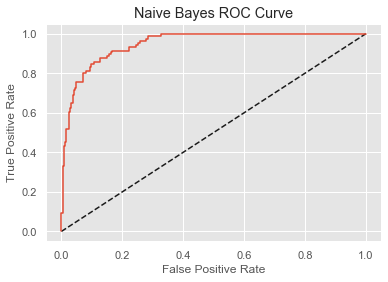

In [115]:
# returns an array with two columns: each column contains probabilities for the target values
# we are selecting the probability of being a 1
y_pred_prob = model.predict_proba(Xb_test)[:,1]

# unpack into false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(yb_test, y_pred_prob)

_ = plt.plot([0,1], [0,1], 'k--')
_ = plt.plot(fpr, tpr, label='NB')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('Naive Bayes ROC Curve')

In [116]:
# compute the AUC
print(roc_auc_score(yb_test, y_pred_prob))

0.9495571813631114


In [117]:
n = classification_report(yb_test, y_pred, output_dict=True)
print(classification_report(yb_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.84      0.89       245
           1       0.71      0.89      0.79       106

    accuracy                           0.86       351
   macro avg       0.83      0.87      0.84       351
weighted avg       0.87      0.86      0.86       351



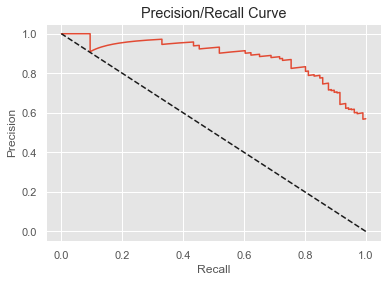

In [118]:
# plot the precision/recall curve
y_pred_prob = model.predict_proba(Xb_test)[:,1]
precision, recall, thresholds = precision_recall_curve(yb_test, y_pred_prob)

_ = plt.plot(recall, precision)
_ = plt.plot([1,0], [0,1], 'k--')
_ = plt.xlabel('Recall')
_ = plt.ylabel('Precision')
_ = plt.title('Precision/Recall Curve')

- The precision/recall curve for Naive Bayes looks a little better than some of the other curves, and this is evident with F1-scores tied with logistic regression for the best 80/90 for AD/non-AD classes.

## 2. Predicting AD with Baseline Biomarkers Summary

- The Logistic Regression and Naive Bayes models performed the best. They achived high detection rates of 90% or more with false positive rates down in the 15% range. 
- The performance of these models was much better than expected, and they outperformed the change in biomarker models. 
    - One possible reason for this is that patients that began the study with Alzheimer's Disease were included in the 'No Change' or negative group for that set of models. The goal was to detect a change in diagnosis, and those patients did not experience a change in diagnosis. One option would be to exclude those that began the study with AD from the analysis. That would reduce the negative class and would not affect the AD class.

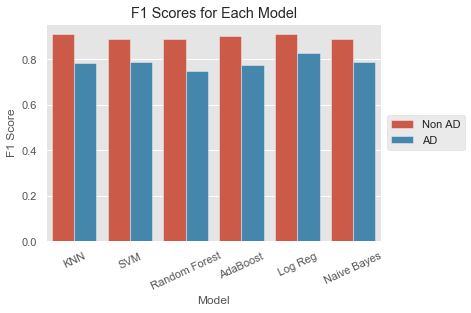

In [119]:
# plot the f1-scores for each model
ml.plot_f1_scores(k, s, r, b, l, n)

- While is should be noted that the data were imbalanced, with more observations from the non-AD (negative) class, this is also representative of the population, where most people don't develop Alzheimer's disease.

## 3. Improving the Models
- The goal of this section is to improve the models. There will be three different approaches to this.
    - Limiting the data to just the clinical biomarkers. Brain scans are expensive for patients, medical care providers, and insurance companies. A model that is capable of predicting Alzheimer's Disease without using brain scan data would be very useful.
    - Using dimension reduction to decrease model complexity and remove some of the background noise that might be hindering model performance.
        - PCA and feature selection
    - Using ensemble techniques in conjunction with dimension reduction, combining multiple models to improve predictions.

#### Clinical Biomarkers Only
- Techniques for model tuning and training have already been displayed, so a single function will be used to evaluate models.
    - The output of this function will be a dataframe that contains summary information for the models.
    - The precision and recall values reported are for the positive (AD) class. F1-scores for both classes are reported.

#### Change in Clinical Biomarkers

In [120]:
df = ml.run_clinical_models(final_exam, biomarkers='deltas')

In [121]:
df

,model,train_acc,test_acc,auc,tp,fn,tn,fp,precision,recall,neg_f1,AD_f1
0,knn,0.883985,0.885630,0.899051,28,26,274,13,0.682927,0.518519,0.933560,0.589474
1,svm,0.858764,0.829912,0.911085,45,9,238,49,0.478723,0.833333,0.891386,0.608108
2,RF,1.000000,0.882698,0.904310,31,23,270,17,0.645833,0.574074,0.931034,0.607843
3,AdaBoost,0.920555,0.870968,0.871854,32,22,265,22,0.592593,0.592593,0.923345,0.592593
4,logreg,0.867591,0.868035,0.920635,47,7,249,38,0.552941,0.870370,0.917127,0.676259
5,bayes,0.839849,0.870968,0.887469,27,27,270,17,0.613636,0.500000,0.924658,0.551020


- The logistic regression model had a very good performance even without using any of the scan data. It had an 87% detection rate for AD, and the false positive rate was only 13%. These are good numbers to use this model to warn patients that they are experiencing a decline towards AD.
- The SVM model performed almost as well as the logistic model with an 83% detection rate and an 17% false positive rate.
- The k-NN model performed well for the negative class, as did random forests, but as the goal is predicting the positive class (Alzheimer's Disease), the logistic model and SVM model are the best.

#### Baseline Clinical Biomarkers

In [122]:
df2 = ml.run_clinical_models(final_exam, biomarkers='baseline')

In [123]:
df2

,model,train_acc,test_acc,auc,tp,fn,tn,fp,precision,recall,neg_f1,AD_f1
0,knn,0.865069,0.862170,0.862079,16,38,278,9,0.640000,0.296296,0.922056,0.405063
1,svm,0.800757,0.747801,0.843786,45,9,210,77,0.368852,0.833333,0.830040,0.511364
2,RF,1.000000,0.850440,0.845722,17,37,273,14,0.548387,0.314815,0.914573,0.400000
3,AdaBoost,0.896595,0.850440,0.800265,22,32,268,19,0.536585,0.407407,0.913118,0.463158
4,logreg,0.688525,0.665689,0.740999,35,19,192,95,0.269231,0.648148,0.771084,0.380435
5,bayes,0.839849,0.756598,0.755517,3,51,255,32,0.085714,0.055556,0.860034,0.067416


- Not surprisingly, the models for the baseline data generally didn't do as well without the brain scan data.
- A major exception to this is the SVM model. The SVM model had an 83% detection rate for AD with a false positive rate of 37%.
    - Considering this model is just using clinical biomarkers and no brain scan data, this is a phenomenal result.
    - This model can be used to help determine which patients should go for brain scans, and help to screen out patients that should not.
- The logistic model did ok with a 65% detection rate, but it had a 49% false positive rate. I would consider these numbers too high to make for a practical predictive model, especially when the SVM model performed so well.

#### Principal Components Analysis for Dimension Reduction

- Change in Biomarkers

In [124]:
# extract and scale the deltas data for ML analysis
feature_names, Xd, yd = ml.get_delta_scaled(final_exam)

In [125]:
# separate into training and test data
Xd_train, Xd_test, yd_train, yd_test = train_test_split(Xd, yd, test_size=0.3, stratify=yd)

In [126]:
# create PCA instance
pca = PCA()

# fit on sample data
pca.fit(Xd_train)

# can use to transform sample data or test/unseen data
Xpca_train_all = pca.transform(Xd_train)
Xpca_test_all = pca.transform(Xd_test)

# examine percent of variance explained by each principal component
print(pca.explained_variance_/np.sum(pca.explained_variance_))

[0.41406619 0.11964532 0.09268934 0.07817502 0.06257427 0.05867272
 0.04995434 0.03836696 0.03333207 0.02781966 0.02180458 0.00289952]


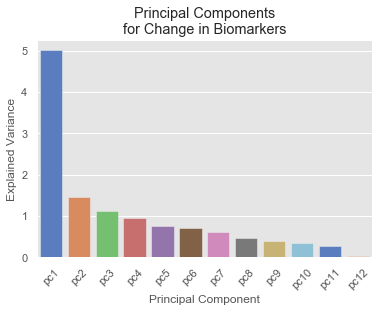

In [127]:
labels = ['pc' + str(i+1) for i in range(feature_names.shape[0])]
ax = sns.barplot(labels, pca.explained_variance_, palette='muted')
_ = plt.setp(ax.get_xticklabels(), rotation=45)
_ = plt.title('Principal Components\nfor Change in Biomarkers')
_ = plt.xlabel('Principal Component')
_ = plt.ylabel('Explained Variance')

- The principal component analysis for the change in biomarker data shows that 10 principal components are required to explain most of the variance in the data. About 95% of the variance can be explained using 9 principal components, so the models will be run using that number of components.

In [128]:
# slice the first 9 components
Xpca_train = Xpca_train_all[:,0:10]
Xpca_test = Xpca_test_all[:,0:10]

In [129]:
df3 = ml.run_models(Xpca_train, Xpca_test, yd_train, yd_test)

In [130]:
df3

,model,train_acc,test_acc,auc,tp,fn,tn,fp,precision,recall,neg_f1,AD_f1
0,knn,0.900378,0.882698,0.882533,22,32,279,8,0.733333,0.407407,0.933110,0.523810
1,svm,0.867591,0.879765,0.934830,45,9,255,32,0.584416,0.833333,0.925590,0.687023
2,RF,1.000000,0.876833,0.934508,21,33,278,9,0.700000,0.388889,0.929766,0.500000
3,AdaBoost,0.957125,0.879765,0.872048,29,25,271,16,0.644444,0.537037,0.929674,0.585859
4,logreg,0.854981,0.870968,0.931088,45,9,252,35,0.562500,0.833333,0.919708,0.671642
5,bayes,0.839849,0.876833,0.912440,26,28,273,14,0.650000,0.481481,0.928571,0.553191


- PCA appeared to stabilize the logistic model over the full feature model, losing some predicitive power with an 80% detection rate, but improving the false positive rate to 14%. The SVM model performed ok after PCA, with a detection rate of 76% and a false positive rate of 18%.
- Since 11 of the 12 principal components appeared to contribute to the variation in the data, the models will be run using 11 PC's for comparison.

In [131]:
# slice the first 11 principal components
Xpca_train = Xpca_train_all[:,0:12]
Xpca_test = Xpca_test_all[:,0:12]

In [132]:
df4 = ml.run_models(Xpca_train, Xpca_test, yd_train, yd_test)
df4

,model,train_acc,test_acc,auc,tp,fn,tn,fp,precision,recall,neg_f1,AD_f1
0,knn,0.894073,0.885630,0.876403,22,32,280,7,0.758621,0.407407,0.934891,0.530120
1,svm,0.867591,0.879765,0.935927,46,8,254,33,0.582278,0.851852,0.925319,0.691729
2,RF,1.000000,0.888563,0.928539,27,27,276,11,0.710526,0.500000,0.935593,0.586957
3,AdaBoost,0.967213,0.879765,0.873919,27,27,273,14,0.658537,0.500000,0.930153,0.568421
4,logreg,0.860025,0.868035,0.928894,45,9,251,36,0.555556,0.833333,0.917733,0.666667
5,bayes,0.839849,0.882698,0.913150,27,27,274,13,0.675000,0.500000,0.931973,0.574468


- The 11 PC data performed very similarly to the 9 version.
- This does not reduce the dimensionality of the data very much, and could still be prone to overfitting on further unseen data.
- The next approach to reducing the dimension in the change in biomarkers data will be to do feature selection analysis. There are multiple approaches that would work for this, including using ANOVA tests to compare within group sum of squares to the total sum of squares for all features. This analysis will use classes created and publicly available on GitHub at [https://github.com/WillKoehrsen/feature-selector](https://github.com/WillKoehrsen/feature-selector)

#### PCA for the Baseline Biomarkers

In [133]:
# extract and scale the deltas data for ML analysis
feature_names, X, y = ml.get_bl_data(final_exam)

In [134]:
# separate into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [135]:
# create PCA instance
pca = PCA()

# fit on sample data
pca.fit(X_train)

# can use to transform sample data or test/unseen data
Xpca_train_all = pca.transform(X_train)
Xpca_test_all = pca.transform(X_test)

# examine percent of variance explained by each principal component
print(pca.explained_variance_/np.sum(pca.explained_variance_))

[0.44745188 0.18406392 0.10630991 0.05290533 0.04331395 0.04177785
 0.03589529 0.02544643 0.02249374 0.02169032 0.01674412 0.00190724]


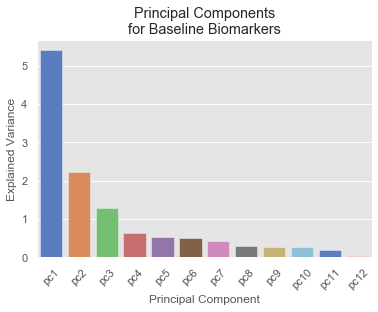

In [136]:
labels = ['pc' + str(i+1) for i in range(feature_names.shape[0])]
ax = sns.barplot(labels, pca.explained_variance_, palette='muted')
_ = plt.setp(ax.get_xticklabels(), rotation=45)
_ = plt.title('Principal Components\nfor Baseline Biomarkers')
_ = plt.xlabel('Principal Component')
_ = plt.ylabel('Explained Variance')

- Over 95% of the variance is explained from the first 9 biomarkers, so those will be used for the pca for the baseline biomarkers.

In [137]:
# slice the first 9 principal components
Xpca_train = Xpca_train_all[:,0:10]
Xpca_test = Xpca_test_all[:,0:10]

In [138]:
df5 = ml.run_models(Xpca_train, Xpca_test, y_train, y_test)
df5

,model,train_acc,test_acc,auc,tp,fn,tn,fp,precision,recall,neg_f1,AD_f1
0,knn,0.881563,0.866097,0.937370,67,39,237,8,0.893333,0.632075,0.909789,0.740331
1,svm,0.884005,0.863248,0.936003,85,21,218,27,0.758929,0.801887,0.900826,0.779817
2,RF,1.000000,0.843305,0.916654,59,47,237,8,0.880597,0.556604,0.896030,0.682081
3,AdaBoost,0.904762,0.871795,0.925529,75,31,231,14,0.842697,0.707547,0.911243,0.769231
4,logreg,0.885226,0.866097,0.937158,86,20,218,27,0.761062,0.811321,0.902692,0.785388
5,bayes,0.698413,0.849003,0.935079,64,42,234,11,0.853333,0.603774,0.898273,0.707182


- The 8 principal component data performed relatively well. The SVM model had an 84% detection rate and the logistic model had an 83% detection rate. Those models both had just 16% false positive rates.
- It is important to note that this did not improve model performance overall that used the full dataset, failing to achieve detection rates as high or false positive rates as low as the models without using PCA.
- An 11 PC test will be examined to see if these numbers can be improved.

In [139]:
# slice the first 11 principal components
Xpca_train = Xpca_train_all[:,0:12]
Xpca_test = Xpca_test_all[:,0:12]

In [140]:
df6 = ml.run_models(Xpca_train, Xpca_test, y_train, y_test)
df6

C:\Users\chuck.tucker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


,model,train_acc,test_acc,auc,tp,fn,tn,fp,precision,recall,neg_f1,AD_f1
0,knn,0.882784,0.866097,0.938814,67,39,237,8,0.893333,0.632075,0.909789,0.740331
1,svm,0.886447,0.866097,0.939584,86,20,218,27,0.761062,0.811321,0.902692,0.785388
2,RF,1.000000,0.849003,0.926454,63,43,235,10,0.863014,0.594340,0.898662,0.703911
3,AdaBoost,0.909646,0.871795,0.928340,70,36,236,9,0.886076,0.660377,0.912959,0.756757
4,logreg,0.877900,0.863248,0.936157,86,20,217,28,0.754386,0.811321,0.900415,0.781818
5,bayes,0.698413,0.846154,0.938082,64,42,233,12,0.842105,0.603774,0.896154,0.703297


- This was not an improvement on the model with fewer features.

#### Feature Selection

- FeatureSelector Class

In [141]:
# import the feature selection class
from feature_selector import FeatureSelector

- This tool will be used to search for three circumstances to consider excluding features:
    - Collinearity
        - If found, linear regression will be used to quantify the relationship and determine whether or not to exclude certain features.
    - Zero Importance Features
        - This tool uses Gradient Boosting to search for zero importance features, that do not contribute to predicting the target.
    - Low Importance Features
        - The Gradient Boosting method will assign normalized importance values based on the amount of variance in the target that is explained by each feature.

- Change in Biomarkers Data

In [142]:
# extract and scale the deltas data for ML analysis
feature_names, Xd, yd = ml.get_delta_scaled(final_exam)

In [143]:
# separate into training and test data
Xd_train, Xd_test, yd_train, yd_test = train_test_split(Xd, yd, test_size=0.3, stratify=yd)

In [144]:
# convert to dataframe for the feature selector
X_train = pd.DataFrame(Xd_train, columns=feature_names)
y_train = pd.DataFrame(yd_train, columns=['y'])

In [145]:
# create an instance
fs = FeatureSelector(data=X_train, labels=y_train)

In [146]:
# identify collinear features
fs.identify_collinear(correlation_threshold=0.75)

1 features with a correlation magnitude greater than 0.75.



In [147]:
# extract the collinear features
correlated_features = fs.ops['collinear']

In [148]:
# print the correlated features
print(correlated_features)

['ADAS13_delta']


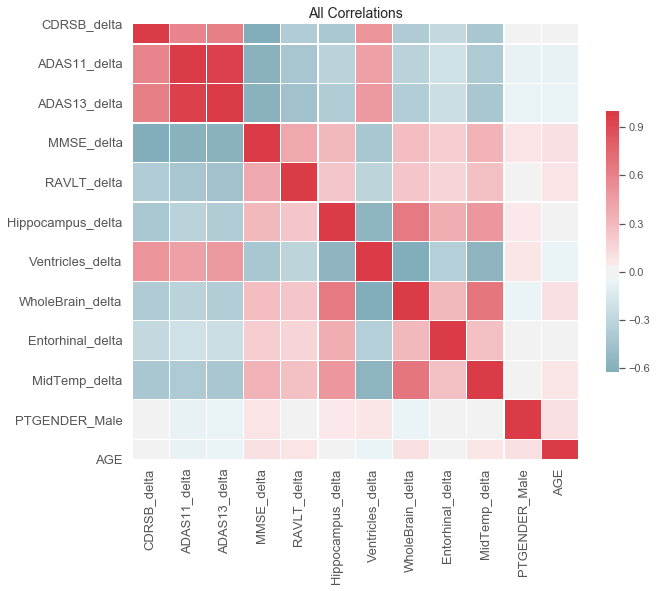

In [149]:
# visualize the heatmap of the correlations
fs.plot_collinear(plot_all=True)

In [150]:
# calculate the r-squared and relationship
clf = linear_model.LinearRegression()
clf.fit(np.array(X_train.ADAS11_delta).reshape(-1,1), np.array(X_train.ADAS13_delta).reshape(-1,1))
r_squared = clf.score(np.array(X_train.ADAS11_delta).reshape(-1,1), np.array(X_train.ADAS13_delta).reshape(-1,1))
r_squared

0.9290259625315768

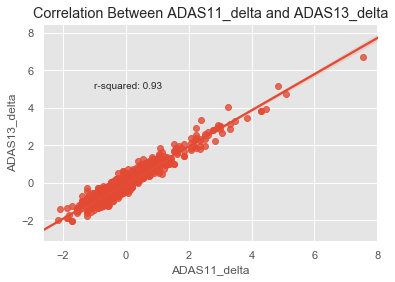

In [151]:
# examine the relationship
_ = sns.regplot(x='ADAS11_delta', y='ADAS13_delta', data=X_train)
_ = plt.title('Correlation Between ADAS11_delta and ADAS13_delta')
_ = plt.text(-1, 5, 'r-squared: {}'.format(round(r_squared, 2)))

In [152]:
# identify zero-importance features
fs.identify_zero_importance(task = 'classification', eval_metric = 'auc', 
                            n_iterations = 10, early_stopping = True)

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[38]	valid_0's auc: 0.923421	valid_0's binary_logloss: 0.246676
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[21]	valid_0's auc: 0.928158	valid_0's binary_logloss: 0.278331
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[4]	valid_0's auc: 0.970526	valid_0's binary_logloss: 0.344834
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[8]	valid_0's auc: 0.930526	valid_0's binary_logloss: 0.330408
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[7]	valid_0's auc: 0.9	valid_0's binary_logloss: 0.349058
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[25]	valid_0's auc: 0.918947	valid_0's binary_logloss: 0.260503
Training

- no features were found with zero importance.

In [153]:
# identify features with low importance
fs.identify_low_importance(cumulative_importance = 0.99)

10 features required for cumulative importance of 0.99 after one hot encoding.
2 features do not contribute to cumulative importance of 0.99.



In [154]:
# examine the low importance feature
low_importance_features = fs.ops['low_importance']
low_importance_features

['ADAS13_delta', 'PTGENDER_Male']

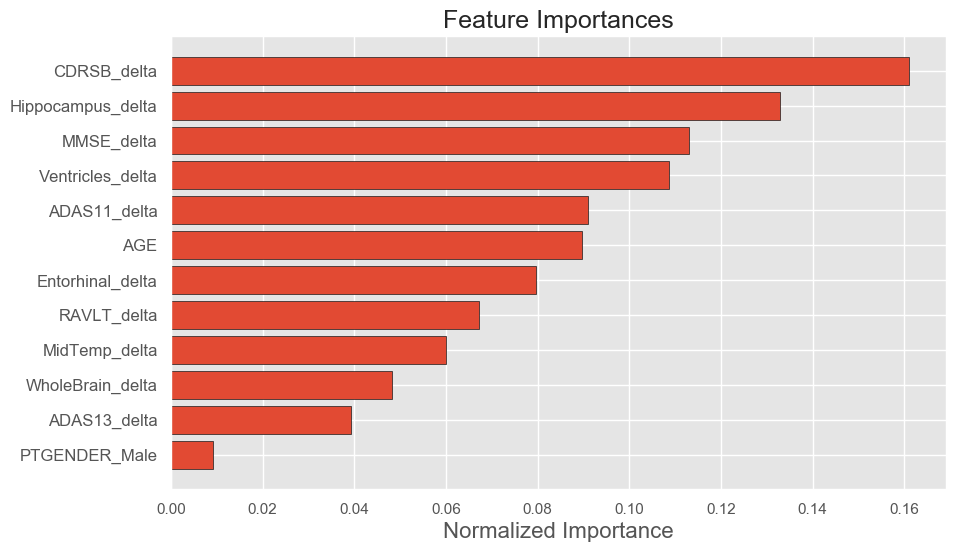

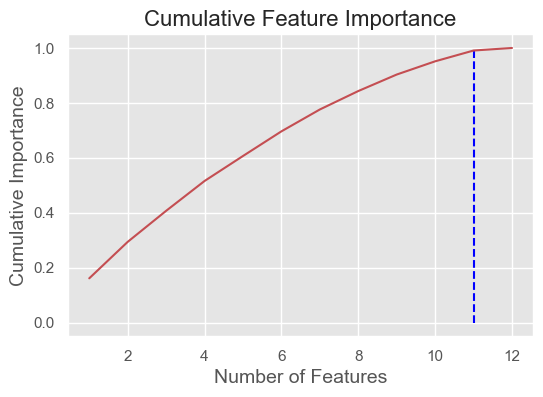

11 features required for 0.99 of cumulative importance


In [155]:
fs.plot_feature_importances(threshold = 0.99, plot_n = 12)

#### Results of Feature Selection for Change in Biomarkers
- ADAS13_delta is collinear with ADAS11_delta
    - ADAS13_delta will be removed from the model
- PTGENDER has a very low importance with the model
    - This is surprising as statistical analysis suggested gender had an impact on certain biomarkers.
    - It would appear, though, that PTGENDER does not influence whether or not a patient was more/less likely to be diagnosed with Alzheimer's Disease during this study.

#### Running the models with a reduced number of features

In [156]:
# drop the features identified from feature selection
X_train.drop(columns=['ADAS13_delta', 'PTGENDER_Male'], inplace=True)
X_test = pd.DataFrame(Xd_test, columns=feature_names)
X_test.drop(columns=['ADAS13_delta', 'PTGENDER_Male'], inplace=True)
X_train = np.array(X_train)
X_test = np.array(X_test)

In [157]:
ml.run_models(X_train, X_test, yd_train, yd_test)

,model,train_acc,test_acc,auc,tp,fn,tn,fp,precision,recall,neg_f1,AD_f1
0,knn,0.896595,0.894428,0.902697,22,32,283,4,0.846154,0.407407,0.940199,0.550000
1,svm,0.906683,0.809384,0.896890,42,12,234,53,0.442105,0.777778,0.878049,0.563758
2,RF,1.000000,0.897361,0.919861,23,31,283,4,0.851852,0.425926,0.941764,0.567901
3,AdaBoost,0.950820,0.850440,0.842947,28,26,262,25,0.528302,0.518519,0.911304,0.523364
4,logreg,0.863808,0.853372,0.915860,43,11,248,39,0.524390,0.796296,0.908425,0.632353
5,bayes,0.839849,0.873900,0.897793,29,25,269,18,0.617021,0.537037,0.925990,0.574257


- The new models that use fewer features had pretty good performance. The models that performed the best changed slightly, but the SVM model had the highest detection rate at 77%, with a false positive rate of 16%. The logistic model performed worse on the positive class, but gained performance in the negative class (76% detection rate and just a 7% false positive rate).

#### Baseline Biomarkers Feature Selection

In [158]:
# extract and scale the deltas data for ML analysis
feature_names, X, y = ml.get_bl_data(final_exam)

In [159]:
# separate into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [160]:
# convert to dataframe for the feature selector
Xf_train = pd.DataFrame(X_train, columns=feature_names)
yf_train = pd.DataFrame(y_train, columns=['y'])

In [161]:
# create an instance
fs = FeatureSelector(data=Xf_train, labels=yf_train)

In [162]:
# identify collinear features
fs.identify_collinear(correlation_threshold=0.9)

1 features with a correlation magnitude greater than 0.90.



In [163]:
# extract the collinear features
correlated_features = fs.ops['collinear']

In [164]:
# print the correlated features
print(correlated_features)

['ADAS13_bl']


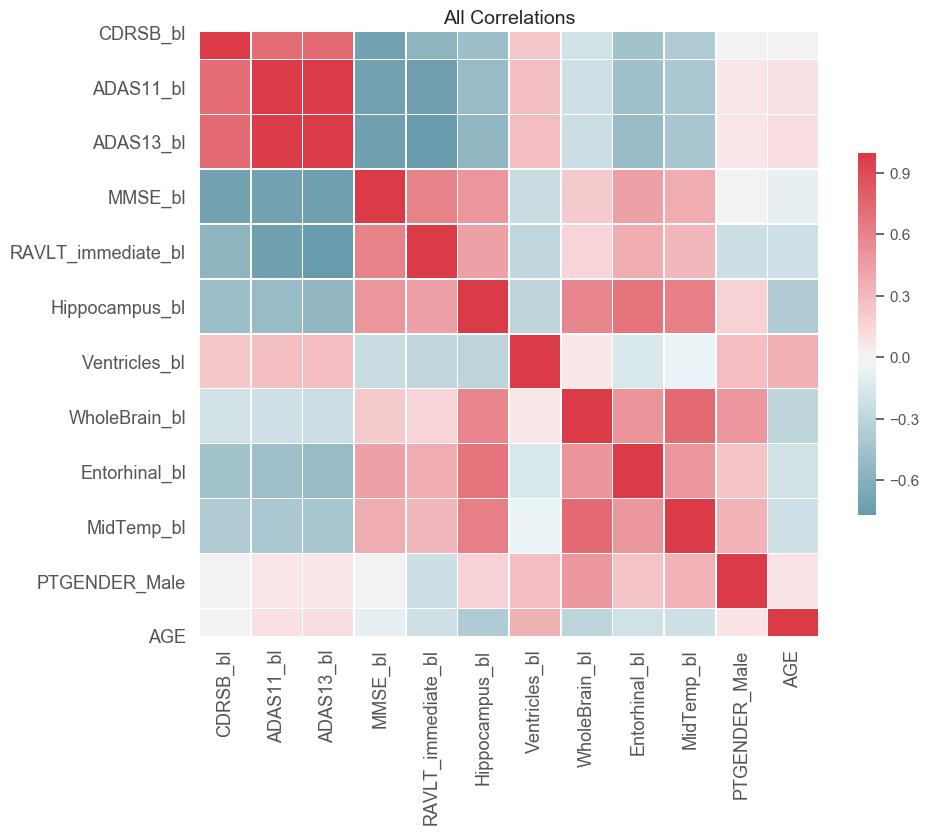

In [165]:
# visualize the heatmap of the correlations
fs.plot_collinear(plot_all=True)

In [166]:
# calculate the r-squared and relationship
clf = linear_model.LinearRegression()
clf.fit(np.array(Xf_train.ADAS11_bl).reshape(-1,1), np.array(Xf_train.ADAS13_bl).reshape(-1,1))
r_squared = clf.score(np.array(Xf_train.ADAS11_bl).reshape(-1,1), np.array(Xf_train.ADAS13_bl).reshape(-1,1))
r_squared

0.9507143405396419

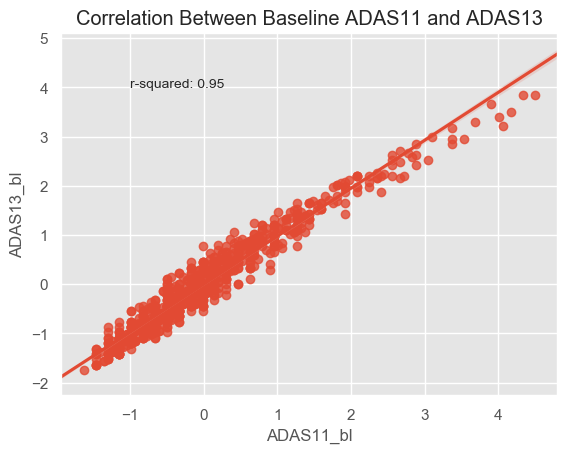

In [167]:
# examine the relationship
_ = sns.regplot(x='ADAS11_bl', y='ADAS13_bl', data=Xf_train)
_ = plt.title('Correlation Between Baseline ADAS11 and ADAS13')
_ = plt.text(-1, 4, 'r-squared: {}'.format(round(r_squared, 2)))

In [168]:
# identify zero-importance features
fs.identify_zero_importance(task = 'classification', eval_metric = 'auc', 
                            n_iterations = 10, early_stopping = True)

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[154]	valid_0's auc: 0.973602	valid_0's binary_logloss: 0.191337
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[65]	valid_0's auc: 0.936204	valid_0's binary_logloss: 0.30835
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[49]	valid_0's auc: 0.943432	valid_0's binary_logloss: 0.295142
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[35]	valid_0's auc: 0.896606	valid_0's binary_logloss: 0.371496
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[16]	valid_0's auc: 0.944689	valid_0's binary_logloss: 0.368788
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	valid_0's auc: 0.971402	valid_0's binary_logloss: 0.216564


- no features were found with zero importance.

In [169]:
# identify features with low importance
fs.identify_low_importance(cumulative_importance = 0.99)

10 features required for cumulative importance of 0.99 after one hot encoding.
2 features do not contribute to cumulative importance of 0.99.



In [170]:
# examine the low importance feature
low_importance_features = fs.ops['low_importance']
low_importance_features

['MMSE_bl', 'PTGENDER_Male']

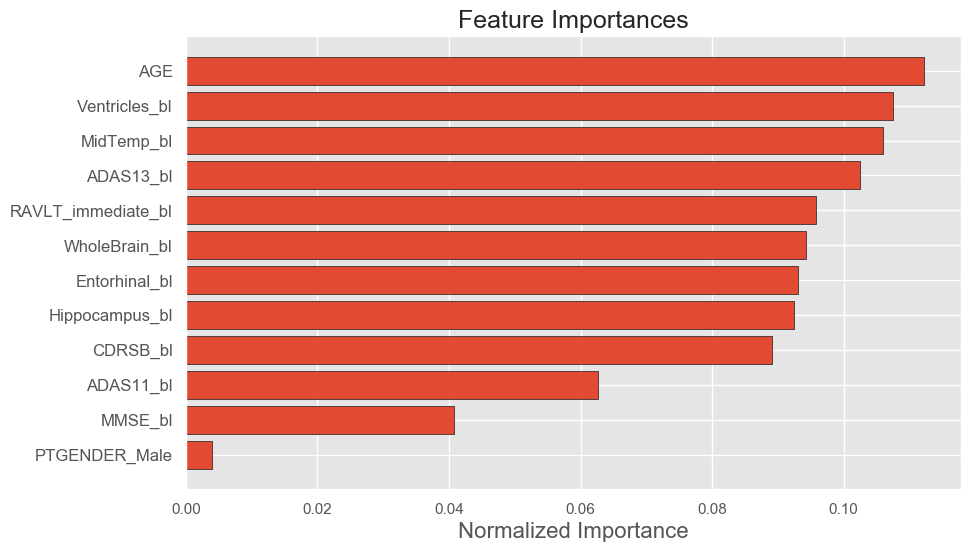

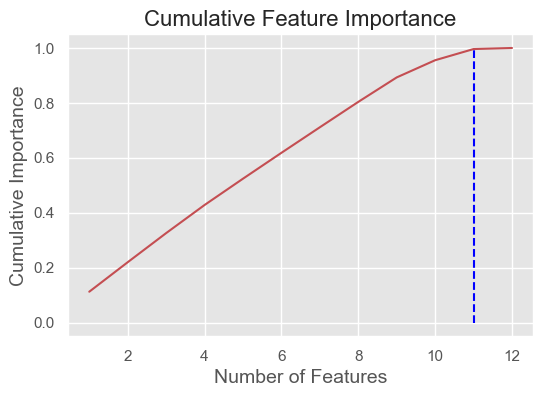

11 features required for 0.99 of cumulative importance


In [171]:
fs.plot_feature_importances(threshold = 0.99, plot_n = 12)

- The feature selection class identified PTGENDER and MMSE_bl as having low importance, however, the MMSE_bl contributes much more than PTGENDER does.
- It is again surprising that the PTGENDER is not contributing to the model, as statistical analysis indicated this was important, however, it is possible that the models are able to extract the differences in the magnitude of values between males/females through the combination of standarization of the feature values and overall relationships between the features for each individual.
- This result again suggests that PTGENDER by itself was not a major contributing factor in whether or not a patient was diagnosed with AD during this study.

#### Running the models with a reduced number of features

In [172]:
# drop the features identified from feature selection
Xf_train.drop(columns=['ADAS13_bl', 'PTGENDER_Male'], inplace=True)
X_test = pd.DataFrame(X_test, columns=feature_names)
X_test.drop(columns=['ADAS13_bl', 'PTGENDER_Male'], inplace=True)
X_train = np.array(Xf_train)
X_test = np.array(X_test)

In [173]:
# run the models with the reduced number of features
ml.run_models(X_train, X_test, y_train, y_test)

,model,train_acc,test_acc,auc,tp,fn,tn,fp,precision,recall,neg_f1,AD_f1
0,knn,0.881563,0.857550,0.923566,62,44,239,6,0.911765,0.584906,0.905303,0.712644
1,svm,0.892552,0.849003,0.921332,89,17,209,36,0.712000,0.839623,0.887473,0.770563
2,RF,1.000000,0.849003,0.916846,64,42,234,11,0.853333,0.603774,0.898273,0.707182
3,AdaBoost,0.898657,0.834758,0.910069,67,39,226,19,0.779070,0.632075,0.886275,0.697917
4,logreg,0.884005,0.857550,0.932923,86,20,215,30,0.741379,0.811321,0.895833,0.774775
5,bayes,0.774115,0.863248,0.928379,85,21,218,27,0.758929,0.801887,0.900826,0.779817


- The models did not quite achieve the detection rates that were found when using all of the features (two achieved 90% detection). The SVM model scored 89% detection, and the Naive Bayes model scored 85% detection rate.
- The Naive Bayes model did improve on the false positive rate slightly with a 9% rate, while the SVM and logistic models had false positive rates near 16%. 
- These numbers were very similar to those that used all features, giving slightly on the positive class and improving slightly on the negative class.
- Overall, it is likely that a small amount of noise was removed from the models, and I would expect the reduced dimension models to perform better on unseen data.

#### Dimension Reduction Summary
- PCA was able to improve of the models a little at the expense of loss of interpretability in the features.
    - This is an acceptable tradeoff, as the ultimate goal is predicting Alzheimer's disease, not in determining which features contributed the most.
- Feature selection was able to identify a couple of features that should be removed from the machine learning analysis, because they do not contribute significantly to the model performance.
    - For both the change in biomarkers and the baseline biomarkers, ADAS13 was removed due to high collinearity with ADAS11. PTGENDER was removed because although it appears to contribute to the magnitude of values for the features, it did not factor in determining whether or not a patient would be diagnosed with Alzheimer's disease in this study.
- Some of the models were run with reduced dimensions after analyzing the model coefficients and importance. In general these made little or no improvements on the models.

## Grand Ensemble Models

- The goal of this section is to create an ensemble model comprised of the best performing models to get the highest detection rate possible. A bonus would be to decrease the false positive rate, but the primary goal is identifying patients that are higher risk for Alzheimer's, so this section will focus on optimizing detection rate (recall).

- Methods
    - The VotingClassifier class from sklearn did not work, as one of the models has a different number of features and uses PCA
        - There may be a way to use this with a pipeline, but this model will be calculated manually to ensure accurate results
    - The best performing 3 or 5 models will be used (so a majority can be reached)
        - The models must either use a different set of the training data or use a different algorithm from the other individual models to be included in the ensemble model

### Change in Biomarkers Ensemble Model
- Best performing models:
    - SVM: 85% detection rate and 15% false positive rate
    - Logistic regression (full feature): 85% detection rate and 13% false positive rate
    - PCA logistic regression: 80% detection rate and 14% false positive rate

In [174]:
# get the data
feature_names, X, y = ml.get_delta_scaled(final_exam)

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# create -1, 1 labels for SVM
ysvm_train = np.where(y_train == 0, y_train - 1, y_train)
ysvm_test = np.where(y_test == 0, y_test - 1, y_test)

In [175]:
# create the models

# create the SVM model
num_features = X_train.shape[1]
param_grid = {'C': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.25, 1.5], 
              'gamma': [(1/(num_features*X_train.var())), (1/num_features)]}
svm = SVC(class_weight='balanced', probability=True)
svm_cv = GridSearchCV(svm, param_grid, cv=5)
svm_cv.fit(X_train, ysvm_train)
C = svm_cv.best_params_['C']
gamma = svm_cv.best_params_['gamma']
svm = SVC(C=C, gamma=gamma, class_weight='balanced', probability=True)
svm.fit(X_train, ysvm_train)
svm_pred_scaled = svm.predict(X_test)
svm_pred = np.where(svm_pred_scaled == -1, svm_pred_scaled + 1, svm_pred_scaled)
svm_prob = svm.predict_proba(X_test)[:,1]

# Logistic regression (full feature)
logreg = linear_model.LogisticRegression(solver='lbfgs', class_weight='balanced', random_state=42)
logreg.fit(X_train, y_train)
logreg_pred = logreg.predict(X_test)
logreg_prob = logreg.predict_proba(X_test)[:,1]

# PCA logistic regression
pca = PCA()
pca.fit(X_train)
Xpca_train_all = pca.transform(X_train)
Xpca_train = Xpca_train_all[:,0:10]
Xpca_test_all = pca.transform(X_test)
Xpca_test = Xpca_test_all[:,0:10]
pca_logreg = linear_model.LogisticRegression(solver='lbfgs', class_weight='balanced', random_state=42)
pca_logreg.fit(Xpca_train, y_train)
pca_logreg_pred = pca_logreg.predict(Xpca_test)
pca_logreg_prob = pca_logreg.predict_proba(Xpca_test)[:,1]

In [176]:
# create a dataframe and count the votes
pred = pd.DataFrame({'svm': svm_pred, 'lr_ff': logreg_pred, 'lr_pca': pca_logreg_pred})
pred.loc[:,'total'] = pred.svm + pred.lr_ff + pred.lr_pca
mapper = {0: 0, 1: 0, 2: 1, 3: 1}
y_pred = pred.total.map(mapper)

In [177]:
# print the confusion matrix
print(confusion_matrix(y_test, y_pred))
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print('True Negatives: {}'.format(tn))
print('False Positives: {}'.format(fp))
print('False Negatives: {}'.format(fn))
print('True Positives: {}'.format(tp))

[[246  41]
 [ 12  42]]
True Negatives: 246
False Positives: 41
False Negatives: 12
True Positives: 42


In [178]:
# print the accuracy
test_acc = (tp + tn) / (tn + fp + tp + fn)
print('Testing accuracy: {}'.format(test_acc))

Testing accuracy: 0.844574780058651


- The ensemble model did not improve on the best model, because of disagreement between the three models used
- Weights will be assigned so that the best performing model is favored to try and improve the predictions

In [179]:
pred.loc[:,'y_pred'] = y_pred

In [180]:
# assign a positive result (prediction of 1) whenever the svm/lr_ff models predict it
svm_add = pred[(pred.y_pred == 0) & (pred.svm == 1)].index
lr_ff_add = pred[(pred.y_pred == 0) & (pred.lr_ff == 1)].index

In [181]:
pred.loc[svm_add, 'y_pred'] = 1
pred.loc[lr_ff_add, 'y_pred'] = 1

In [182]:
y_pred_weighted = pred.y_pred

In [183]:
# print the confusion matrix
print(confusion_matrix(y_test, y_pred_weighted))
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_weighted).ravel()
print('True Negatives: {}'.format(tn))
print('False Positives: {}'.format(fp))
print('False Negatives: {}'.format(fn))
print('True Positives: {}'.format(tp))

[[242  45]
 [ 10  44]]
True Negatives: 242
False Positives: 45
False Negatives: 10
True Positives: 44


In [184]:
# print the accuracy
test_acc = (tp + tn) / (tn + fp + tp + fn)
print('Testing accuracy: {}'.format(test_acc))

Testing accuracy: 0.8387096774193549


- Updating the predictions so that the best models were always counted as positive improved the detection rate to 82%, still lower than the best two models independently. This is likely due to a different random state when running the models.
- This is an important result, because this probably means the original models were overfitting slightly.
- This final model has a detection rate of 82% and a false positive rate of 16%.
- This would be the recommended model for use, though more unseen data would really help to assess all of the models' performances.

### Baseline Biomarkers Ensemble Model
- Best performing models:
    - Logistic regression
    - SVM
    - SVM omitting ADAS13_bl and PTGENDER

In [185]:
# get the data
feature_names, X, y = ml.get_bl_data(final_exam)

# split the data (use a different random state for better generalization)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12, stratify=y)

# create -1, 1 labels for SVM
ysvm_train = np.where(y_train == 0, y_train - 1, y_train)
ysvm_test = np.where(y_test == 0, y_test - 1, y_test)

In [186]:
# create the models

# logistic regression
logreg = linear_model.LogisticRegression(solver='lbfgs', class_weight='balanced', random_state=20)
logreg.fit(X_train, y_train)
logreg_pred = logreg.predict(X_test)
logreg_prob = logreg.predict_proba(X_test)[:,1]

# SVM
num_features = X_train.shape[1]
param_grid = {'C': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.25, 1.5], 
              'gamma': [(1/(num_features*X_train.var())), (1/num_features)]}
svm = SVC(class_weight='balanced', probability=True)
svm_cv = GridSearchCV(svm, param_grid, cv=5)
svm_cv.fit(X_train, ysvm_train)
C = svm_cv.best_params_['C']
gamma = svm_cv.best_params_['gamma']
svm = SVC(C=C, gamma=gamma, class_weight='balanced', probability=True)
svm.fit(X_train, ysvm_train)
svm_pred_scaled = svm.predict(X_test)
pca_svm_pred = np.where(svm_pred_scaled == -1, svm_pred_scaled + 1, svm_pred_scaled)
pca_svm_prob = svm.predict_proba(X_test)[:,1]

# SVM removing PTGENDER and ADAS11_bl
Xf_train = pd.DataFrame(X_train, columns=feature_names)
Xf_train.drop(columns=['ADAS11_bl', 'PTGENDER_Male'], inplace=True)
Xf_test = pd.DataFrame(X_test, columns=feature_names)
Xf_test.drop(columns=['ADAS11_bl', 'PTGENDER_Male'], inplace=True)
Xsv_train = np.array(Xf_train)
Xsv_test = np.array(Xf_test)
num_features = Xsv_train.shape[1]
param_grid = {'C': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.25, 1.5], 
              'gamma': [(1/(num_features*Xsv_train.var())), (1/num_features)]}
svm_rmv = SVC(class_weight='balanced', probability=True)
svm_rmv_cv = GridSearchCV(svm_rmv, param_grid, cv=5)
svm_rmv_cv.fit(Xsv_train, ysvm_train)
C = svm_rmv_cv.best_params_['C']
gamma = svm_rmv_cv.best_params_['gamma']
svm_rmv = SVC(C=C, gamma=gamma, class_weight='balanced', probability=True)
svm_rmv.fit(Xsv_train, ysvm_train)
svm_rmv_pred_scaled = svm_rmv.predict(Xsv_test)
rmv_svm_pred = np.where(svm_rmv_pred_scaled == -1, svm_rmv_pred_scaled + 1, svm_rmv_pred_scaled)
rmv_svm_prob = svm_rmv.predict_proba(Xsv_test)[:,1]

In [187]:
# create a dataframe and count the votes
pred_bl = pd.DataFrame({'lr': logreg_pred, 'pca_svm': pca_svm_pred, 'svm_rmv': rmv_svm_pred})
pred_bl.loc[:,'total'] = pred_bl.lr + pred_bl.pca_svm + pred_bl.svm_rmv
mapper = {0: 0, 1: 0, 2: 1, 3: 1}
y_pred_bl = pred_bl.total.map(mapper)

In [188]:
# print the confusion matrix
print(confusion_matrix(y_test, y_pred_bl))
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_bl).ravel()
print('True Negatives: {}'.format(tn))
print('False Positives: {}'.format(fp))
print('False Negatives: {}'.format(fn))
print('True Positives: {}'.format(tp))

[[211  34]
 [ 12  94]]
True Negatives: 211
False Positives: 34
False Negatives: 12
True Positives: 94


In [189]:
# print the accuracy
test_acc = (tp + tn) / (tn + fp + tp + fn)
print('Testing accuracy: {}'.format(test_acc))

Testing accuracy: 0.8689458689458689


- The ensemble model produced 89% prediction rate with an 14% false positive rate.
- Though the total detection rate is a little lower than the best models, I think this model will have the best generalization ability compared to any of the individual models.
- The random state being different could have affected the results, but again, this is important for the ability to generalize.

## Machine Learning Summary
- This analysis produced several models that demonstrated the ability to predict Alzheimer's Disease:
    - Predict a progression to Alzheimer's based on changes in biomarkers
    - Predict Alzheimer's Disease using only initial measurements from a patient's first exam
    - Predict Alzheimer's Disease using only clinical biomarkers from an initial exam (not using brain scan data)
- A variety of tools were used to create classification models and modify them to improve results:
    - Classification algorithms: KNN, SVM, Random Forest, AdaBoost, Logistic Regression, and Naive Bayes
    - Dimension reduction and feature selection: coefficients from individual models, principal component analysis, and feature selection tools
    - Combining multiple models for an ensemble approach

- The individual models that performed well for predicting Alzheimer's Disease
    - Change in biomarkers:
        - Logistic regression
        - Logistic regression on principal components
        - SVM with ADAS13_delta and PTGENDER removed
    - Baseline biomarkers:
        - Logistic regression
        - SVM
        - SVM with ADAS13_bl and PTGENDER removed
- Individual models that performed well on clinical biomarkers only
    - Change in biomarkers:
        - Logistic regression
        - SMV
    - Baseline biomarkers:
        - SVM
- Ensemble models showed sufficient detection rates with acceptable false positive rates

#### Important Uses for Models
- Flagging patients as being higher risk of Alzheimer's disease and needing to get brain scans using only data from clinical exams collected at a patient's first visit
- Using combined clinical data and brain scan data to predict which patients are higher risk of developing Alzheimer's disease after only one visit
- Using data collected over multiple visits to determine which patients are experience a progression in biomarkers that suggests they are at risk of developing Alzheimer's Disease

#### Potential Gains from Using These Models
- Early detection of at risk patients
    - signify which patients should go for brain scans
    - begin early treatment
    - prepare financially and emotionally for the disease
- Monetary gains
    - help determine which patients should/should not schedule expensive brain scans
        - helps patients, hospitals, and insurance companies save money
    - some early treatment options are inexpensive and have long term effects that can reduce the total cost to the patient